<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Fractional and Volterra processes in Finance  </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Challenge 2 -  Pricing by Fourier </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>

- Soukaina Bruneau
- Sylvain Rakotomalala
- Saad Souilmi

<font color='red'>**DEADLINE: March 10 before 10 AM to be sent by email to eduardo.abi-jaber@polytechnique.edu**</font>

 <font color='red'>**Please send both pdf ipynb files with name : Group6_Challenge2**
</font>

TODO:

    - Implémenter différentes quadratures.
    - Rendre le code efficace.

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1. Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

1. Implement the characteristic function of the conventional Heston model
\begin{align*}
	dS_t &=S_t \sqrt{V_t} dB_t, \quad d\langle W, B\rangle_t = \rho dt \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW_t, \quad V_0 \geq 0, S_0=1
\end{align*}
    
Denote by 
$$ \Phi_{T}(z) = \mathbb E\left[ \exp\left( \mathrm i z \log S_T \right) \right]$$

2. Price Put options pricer using  Lewis inversion formula
$$ \mathbb E (K-S_T)^+ = K - \frac {\sqrt{S_0K}}{\pi } \int_{\mathbb R_+} \Re \left(e^{izk} \frac{\Phi_T(z-\frac{i}{2})}{z^2 + \frac 1 4 }\right) dz,$$
with $k=\log(S_0/K)$.

3. Plot implied vol surface (slice by slice for different maturity slices $T$ ranging from 0.02 to 1)

4. Set $\kappa=\eta=1/\epsilon$ and plot the atm skew as $\epsilon \to 0$ and comment.  


Calls are obtained by Put call parity (r=0).


To sanity check your code here are two value of references for prices of call.

Recall: 



<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);"> 
    <strong>Theorem</strong>. (Characteristic function in Heston model)  For $v\in \mathbb R$, 
$$
\mathbb E[\exp\left(iv\log S_T \right) |\mathcal F_t]  = \exp\left( iv\log S_t + \phi(T-t)  + \psi(T-t) V_t \right),
$$
with 
\begin{align*}
\psi(t)&= \frac{\beta(v)-D(v)}{\eta^2}\frac{1-e^{-D(v)t}}{1-G(v)e^{-D(v)t}}\\
\phi(t)&= \frac{\theta}{\eta^2}\left((\beta(v)-D(v))t - 2 \log\left( \frac{G(v)e^{-D(v)t}-1}{G(v)-1} \right)\right)  \\
\beta(v) &= \kappa - iv \rho\eta, \quad  D(v)= \sqrt{\beta(v)^2  + \eta^2 v(i+v)}, \quad G(v) =\frac{\beta(v)-D(v)}{\beta(v)+ D(v)}.
\end{align*}
</div>
   

In [1]:
%load_ext jupyter_black
import jax
import jax.numpy as jnp
import jax.random as random
import numpy as np
import jax.scipy as jsp
from scipy.integrate import quad
from scipy.stats import norm
from functools import partial
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
import scienceplots
from scipy.stats import norm
from scipy.special import gamma, roots_laguerre
import scipy.optimize as optim
from sklearn.metrics import r2_score
import scipy.stats as sts


plt.style.use(["science", "no-latex", "grid"])

key = random.PRNGKey(1337)
rng = np.random.default_rng(seed=1337)

In [2]:
kappa = 1.5768
theta = 0.0398 * 1.5768
V0 = 0.0175
rho = -0.5711
eta = 0.5751
sigma = 0.5751

model = {"var": V0, "kappa": kappa, "theta": theta, "rho": rho, "eta": eta}

r = 0.0
K = 1
s0 = 1

ref_value_T1y = 0.05785155435  # See fang osterlee p15
ref_value_T10y = 0.22318945791474590  # See fang osterlee p15

In [4]:
def ft(
    z: float,
    spot: float,
    ttm: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
) -> complex:
    """Compute fourrier transform of log(S_T) in the heston model
    Args:
        - z: evaluation point
        - spot: initial spot value
        - ttm: time to maturity
        - var: initial value of variance
        - kappa: mean reversion rate
        - rho: correlation
        - eta: vovol
        - theta: long term mean
    Return:
        - float: fourrier transform
    """
    beta = kappa - 1j * z * rho * eta
    D = np.sqrt(beta**2 + eta**2 * z * (z + 1j))
    G = (beta - D) / (beta + D)
    phi = (
        theta
        * ((beta - D) * ttm - 2 * np.log((G * np.exp(-D * ttm) - 1) / (G - 1)))
        / eta**2
    )
    psi = (beta - D) * (1 - np.exp(-D * ttm)) / (eta**2 * (1 - G * np.exp(-D * ttm)))

    return np.exp(1j * z * np.log(spot) + phi + psi * var)


def put_option(
    spot: float,
    ttm: float,
    strike: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
    guassl: bool = False,
    deg: int = 100,
) -> float:
    """Compute Put option price in the Heston model
    Args:
        - spot: initial spot value
        - ttm: time to maturity
        - strike: option strike
        - var: initial value of variance
        - kappa: mean reversion rate
        - rho: correlation
        - eta: vovol
        - theta: long term mean
    Returns:
        - float: Put option price
    """
    k = np.log(spot / strike)
    integrand = lambda z: np.real(
        np.exp(1j * z * k)
        * ft(z - 0.5 * 1j, spot, ttm, var, kappa, rho, eta, theta)
        / (z**2 + 1 / 4)
    )
    if guassl:
        x, w = roots_laguerre(deg)
        return strike - np.sqrt(spot * strike) * (integrand(x) * np.exp(x)).dot(w)
    return strike - np.sqrt(spot * strike) * quad(integrand, 0, np.infty)[0] / np.pi

<div class="alert alert-warning">We attempted to add an option to use the gauss laguerre quadrature, but we encountered overflow errors for high degrees we could only go up to $n\approx100$ which led to very inaccurate prices.</div>

In [5]:
# sanity check
print(
    rf"error for maturity T=1Y: {np.abs(put_option(s0, 1, K, **model) - ref_value_T1y)}"
)
print(
    rf"error for maturity T=10Y: {np.abs(put_option(s0, 10, K, **model) - ref_value_T10y)}"
)

error for maturity T=1Y: 6.7978955797798335e-12
error for maturity T=10Y: 3.1988023341256167e-12


<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">We will compute the implied volatility using the Newton-Raphson algorithm:
$$\sigma_0 = \sqrt{\frac{2|\log(S_0/K)|}{T}},\quad\quad \sigma_n = \sigma_{n-1} + \frac{P - P^{\text{BS}}(\sigma_{n-1})}{\partial_\sigma P^{\text{BS}}(\sigma_{n-1})} $$</div>

In [6]:
def implied_vol(
    spot: float,
    ttm: float,
    strike: float,
    price: float,
    epochs: float = 100,
    eps: float = 1e-10,
) -> float:
    """Compute implied vol
    Args:
        - spot: initial spot value
        - ttm: time to maturity
        - strike: option strike
        - price: price to be matched
        - epochs: number of newton-raphson iterations
    Returns:
        - float: implied volatility
    """
    m = np.log(spot / strike)
    price = spot - strike + price
    vol = np.sqrt(2 * np.abs(m) / ttm)
    d1 = m / (np.sqrt(ttm) * vol) + 0.5 * np.sqrt(ttm) * vol if not vol == 0 else 0
    d2 = d1 - np.sqrt(ttm) * vol
    bs_price = spot * norm.cdf(d1) - strike * norm.cdf(d2)
    vega = spot * norm.pdf(d1) * np.sqrt(ttm)
    for epoch in range(epochs):
        vol += (price - bs_price) / (vega)
        d1 = m / (np.sqrt(ttm) * vol) + 0.5 * np.sqrt(ttm) * vol if not vol == 0 else 0
        d2 = d1 - np.sqrt(ttm) * vol
        bs_price = spot * norm.cdf(d1) - strike * norm.cdf(d2)
        if np.abs(price - bs_price) <= 1e-7:
            break
        vega = spot * norm.pdf(d1) * np.sqrt(ttm)

    return vol


def bs_price(spot, ttm, strike, vol):
    if vol == 0:
        return np.max(spot - strike, 0)
    m = np.log(spot / strike)
    d1 = m / (np.sqrt(ttm) * vol) + 0.5 * np.sqrt(ttm) * vol
    d2 = d1 - np.sqrt(ttm) * vol
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

In [7]:
strike_grid = np.linspace(0.8, 1.2, 8)
ttm_grid = np.linspace(0.02, 1, 10)
vol_surface = np.zeros((len(ttm_grid), len(strike_grid)))
errors = np.zeros((len(ttm_grid), len(strike_grid)))

for i, ttm in enumerate(ttm_grid):
    for j, strike in enumerate(strike_grid):
        model_price = put_option(
            s0,
            ttm,
            strike,
            **model,
        )
        vol_surface[i, j] = implied_vol(s0, ttm, strike, model_price)
        errors[i, j] = np.abs(
            s0 - strike + model_price - bs_price(s0, ttm, strike, vol_surface[i, j])
        )

In [8]:
errors.max()

9.875417535800283e-08

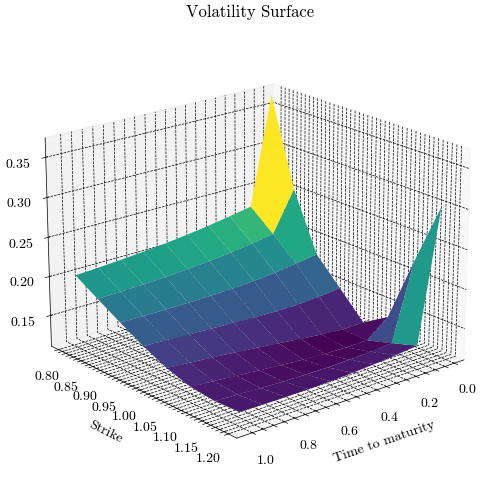

In [9]:
x = np.outer(ttm_grid, np.ones_like(strike_grid))
y = np.outer(strike_grid, np.ones_like(ttm_grid)).T
# generating a figure and a 3D axes
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection="3d")
# plotting the 3D surface plot
ax.plot_surface(x, y, vol_surface, cmap="viridis", edgecolor="none")
ax.view_init(20, 50)
plt.xlabel("Time to maturity")
plt.ylabel("Strike")
ax.set_zlabel("Volatility")
plt.title("Volatility Surface")
plt.show()

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">The at the money skew is :
$$\psi(T) = \frac{\partial}{\partial k}\sigma_{\text{BS}}(k, T)\Bigg|_{k=0} = -K\frac{\partial}{\partial K}\sigma_{\text{BS}}\Bigg|_{K=S_0}$$
</div>

In [482]:
eps_range = [0.01, 0.3, 0.5, 1.0]
ttm_grid = np.linspace(0.02, 1, 10)
atm_skew = np.zeros((len(eps_range), len(ttm_grid)))
dK = 1e-6

for i, eps in enumerate(eps_range):
    for j, ttm in enumerate(ttm_grid):
        price1 = put_option(s0, ttm, s0 + dK, V0, 1 / eps, rho, 1 / eps, theta)
        price2 = put_option(s0, ttm, s0 - dK, V0, 1 / eps, rho, 1 / eps, theta)
        vol1 = implied_vol(s0, ttm, s0 + dK, price1)
        vol2 = implied_vol(s0, ttm, s0 - dK, price2)
        atm_skew[i, j] = -s0 * (vol1 - vol2) / (2 * dK)

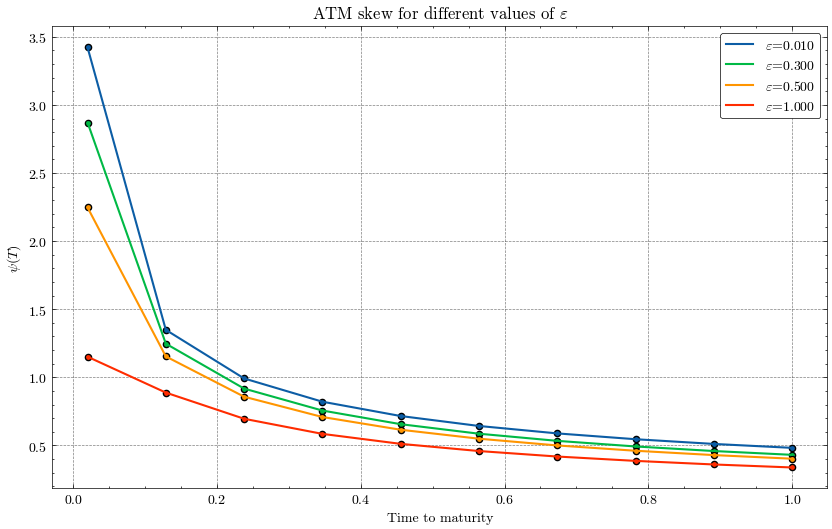

In [483]:
fig = plt.figure(figsize=(10, 6))

for index, eps in enumerate(eps_range):
    plt.plot(ttm_grid, atm_skew[index, :], lw=1.5, label=rf"$\varepsilon$={eps:.3f}")
    plt.scatter(ttm_grid, atm_skew[index, :], marker="o", edgecolors="k", s=20)
legend = plt.legend(
    fancybox=True,
    edgecolor="black",
)
legend.get_frame().set_linewidth(0.5)
plt.title(r"ATM skew for different values of $\varepsilon$")
plt.xlabel("Time to maturity")
plt.ylabel(r"$\psi(T)$")
plt.show()

<div class="alert alert-success"> We see that heston models with high volatility of variance $\eta$ and mean reversion rates $\kappa$ ($\varepsilon \to 0$) exhibit power law for the ATM skew at short maturities, which is realistic relative to real market observations.</div>

### Implementing the COS method in [Fang and Osterlee (2009)](https://mpra.ub.uni-muenchen.de/7700/1/MPRA_paper_7700.pdf): 

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">
    The Fourrier cosine series expansion of a function $f$ supported on $[0, \pi]$ is given by: 
$$ \forall \theta\in[0, \pi]\quad f(\theta) = \frac{A_0}{2} + \sum _{k\geqslant 1} A_k \cos(k\theta)\quad\mbox{such that}\quad \forall k\in \mathbb N\quad A_k = \frac{2}{\pi}\int_{0}^\pi f(\theta)\cos(k\theta)\,d\theta$$
If $f$ is supported on $[a, b]$, by a simple change of variable we obtain:
$$ \forall x\in[a, b]\quad f(x) = \frac{A_0}{2} + \sum _{k\geqslant 1} A_k \cos\left(k\pi \frac{x-a}{b-a}\right)\quad\mbox{such that}\quad \forall k\in \mathbb N\quad A_k = \frac{2}{b-a}\int_{a}^b f(x)\cos\left(k\pi\frac{x-a}{b-a}\right)\,dx$$

When the fourrier Transform $\hat f$ exists, the function has to decay to zero in $\pm \infty$. We can thus make the approximation:
$$ \hat f_1(\xi) = \int_a^b e^{ix\xi}f(x)\,dx \approx \int_\mathbb R e^{ix\xi}f(x)\,dx = \hat f(\xi)$$
In our case, we are interested in computing:
$$ v(x, t; \theta) = \int_\mathbb R G(y; \theta)p(y|x)\,dy$$
Where $\log(S_T/K) | \log(S_t/K)=x \sim p(.|x)$, $G$ is the terminal payoff of the contract and $\theta$ are the contracts parameters e.g: $K, T$. We know that in the heston model $p(.|x)$ has a fourrier transform, we can thus make use the following approximation:
$$ v(x, t; \theta) \approx \int_a^b  G(y; \theta)p(y|x)\,dy$$
$$\forall y\in[a, b]\quad p(y|x)\approx \frac{A_0(x)}{2} + \sum _{k\geqslant 1} A_k(x) \cos\left(k\pi \frac{y-a}{b-a}\right)\quad\mbox{such that}\quad \forall k\in \mathbb N\quad A_k(x) = \frac{2}{b-a}\Re\left\{\hat p_1\left(\frac{k\pi}{b-a}\right)e^{-i\frac{k\pi a}{b-a}}\right\}$$
By taking :
$$\forall k\in\mathbb N\quad V_k = \frac{2}{b-a} \int_{a}^b G(y; \theta) \cos\left(k\pi \frac{y-a}{b-a}\right)\,dy$$
$$v(x, t; \theta) \approx \sum_{k=0}^\infty ' \Re\left\{\hat p_1\left(\frac{k\pi}{b-a}\right)e^{-i\frac{k\pi a}{b-a}}\right\} V_k\approx\sum_{k=0}^\infty ' \Re\left\{\hat p\left(\frac{k\pi}{b-a}\right)e^{-i\frac{k\pi a}{b-a}}\right\} V_k$$
Where $\sum'$ means that the first term is weighted by $1/2$. Thus :
$$v(x, t; T, K) \approx\sum_{k=0}^\infty ' \Re\left\{ \Phi_T\left(\frac{k\pi}{b-a}\right)\exp\left(-i\frac{k\pi}{b-a}\left(a+\log(K)\right)\right)\right\} V_k$$
In our case we are attempting to price put option. Thus:
$$\begin{aligned}\forall k\in\mathbb N \quad V_k &= \frac{2}{b-a}\int_a^bK(1-e^{y})^+\cos\left(k\pi \frac{y-a}{b-a}\right)\,dy = \frac{2K}{b-a} \left(\psi_k(a,0) - \chi_k(a,0)\right) \end{aligned}$$
$$\mbox{Where :}\quad \forall k\in\mathbb N\quad\psi_k(a,0)=\frac{1}{1 +\left(\frac{k\pi}{b-a}\right)^2} \left[\cos\left(\frac{k\pi a}{b-a}\right) - e^a - \frac{k\pi}{b-a}\sin\left(\frac{k\pi a}{b-a}\right)\right]$$
$$ \psi_k(a,0) = \frac{a-b}{k\pi}\sin\left(\frac{k\pi a}{b-a}\right)\quad\mbox{if } k\neq 0 \mbox{ or } 0\mbox{ otherwise}$$
For the truncation, the article suggests for the Heston model:
$$[a, b] = \left[c_1 \pm 12\sqrt{|c_2|}\right]\quad \mbox{where: }c_n = \frac{d^n}{dt^n}\log\left(\mathbb E\left[e^{t\log(S_T/K)}\right]\right)\Bigg|_{t=0}$$
The expressions of $c_1$ and $c_2$ for the heston model are given in the article. </div>

In [14]:
def density(
    y: jax.Array,
    spot: float,
    ttm: float,
    strike: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
    N: int = 96,
    L: float = 12,
) -> jax.Array:
    # Compute truncation range
    c1 = (1 - np.exp(-kappa * ttm)) * (theta / kappa - var) / (
        2 * kappa
    ) - theta * ttm / (
        2 * kappa
    )  # first cumulant
    c2 = (
        eta
        * ttm
        * kappa
        * np.exp(-kappa * ttm)
        * (var - theta / kappa)
        * (8 * kappa * rho - 4 * eta)
        + kappa
        * rho
        * eta
        * (1 - np.exp(-kappa * ttm))
        * (16 * theta / kappa - 8 * var)
        + 2 * theta * ttm * (-4 * kappa * rho * eta + eta**2 + 4 * kappa**2)
        + eta**2
        * (
            (theta / kappa - 2 * var) * np.exp(-2 * kappa * ttm)
            + theta * (6 * np.exp(-kappa * ttm) - 7) / kappa
            + 2 * var
        )
        + 8 * kappa**2 * (var - theta / kappa) * (1 - np.exp(-kappa * ttm))
    ) / (8 * kappa**3)
    a, b = c1 - L * np.sqrt(np.abs(c2)), c1 + L * np.sqrt(np.abs(c2))

    # Compute expansion coefficients
    A = (
        2
        * np.real(
            np.array(
                [
                    ft(k * np.pi / (b - a), spot, ttm, var, kappa, rho, eta, theta)
                    for k in range(N)
                ]
            )
            * np.exp(-1j * (a + np.log(strike)) * np.arange(N) * np.pi / (b - a))
        )
        / (b - a)
    )
    A[0] = A[0] / 2

    return np.sum(
        A * np.cos(np.arange(N) * np.pi * (y.reshape(-1, 1) - a) / (b - a)), axis=1
    )

In [15]:
# sanity check
y = np.linspace(-2.5, 2, num=100)
p1y = density(y, s0, 1, s0, **model)
p10y = density(y, s0, 10, s0, **model)

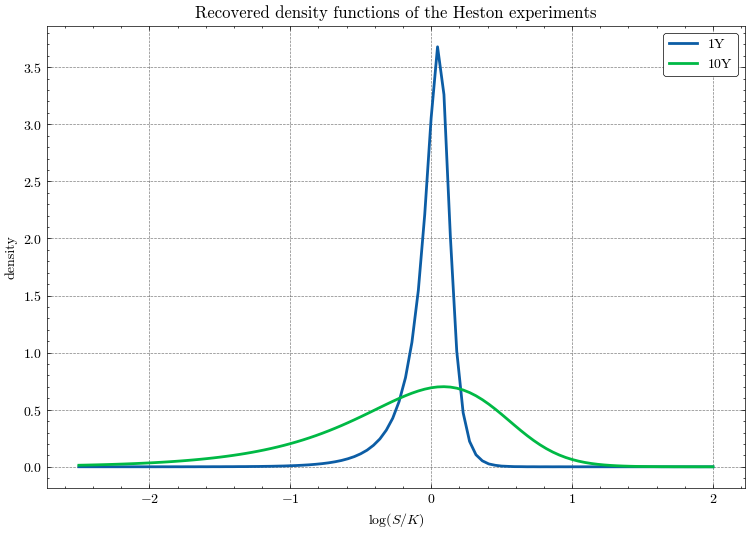

In [16]:
fig = plt.figure(figsize=(9, 6))
plt.plot(y, p1y, lw=2, label="1Y")
plt.plot(y, p10y, lw=2, label="10Y")
legend = plt.legend(
    fancybox=True,
    edgecolor="black",
)
legend.get_frame().set_linewidth(0.5)
plt.xlabel(r"$\log(S/K)$")
plt.ylabel("density")
plt.title("Recovered density functions of the Heston experiments")
plt.show()

<div class="alert alert-success">We manage to recover the same density of the heston process for the parameters used in the paper.</div>

In [17]:
# @partial(jax.jit, static_argnames=("N",))
def put_option_cos(
    spot: float,
    ttm: float,
    strike: jax.Array,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
    N: int = 96,
    L: float = 12,
) -> jax.Array:
    """Computes price of put options for multiple strikes using the cos method under the heston model
    Args:
        - spot: initial spot value
        - ttm: time to maturity
        - strike: option strike
        - var: initial value of variance
        - kappa: mean reversion rate
        - rho: correlation
        - eta: vovol
        - theta: long term mean
        - N: Length of cosine series expansion
        - L: Truncation parameter
    Returns:
        - jax.Array: put option prices for different strikes
    """
    # Compute truncation range
    c1 = (1 - np.exp(-kappa * ttm)) * (theta / kappa - var) / (
        2 * kappa
    ) - theta * ttm / (
        2 * kappa
    )  # first cumulant
    c2 = (
        eta
        * ttm
        * kappa
        * np.exp(-kappa * ttm)
        * (var - theta / kappa)
        * (8 * kappa * rho - 4 * eta)
        + kappa
        * rho
        * eta
        * (1 - np.exp(-kappa * ttm))
        * (16 * theta / kappa - 8 * var)
        + 2 * theta * ttm * (-4 * kappa * rho * eta + eta**2 + 4 * kappa**2)
        + eta**2
        * (
            (theta / kappa - 2 * var) * np.exp(-2 * kappa * ttm)
            + theta * (6 * np.exp(-kappa * ttm) - 7) / kappa
            + 2 * var
        )
        + 8 * kappa**2 * (var - theta / kappa) * (1 - np.exp(-kappa * ttm))
    ) / (8 * kappa**3)
    a, b = c1 - L * np.sqrt(np.abs(c2)), c1 + L * np.sqrt(np.abs(c2))
    # Compute expansion coefficients
    chi = (
        np.cos(np.pi * a * np.arange(N) / (b - a))
        - np.exp(a)
        - np.pi * np.arange(N) * np.sin(np.pi * a * np.arange(N) / (b - a)) / (b - a)
    ) / (1 + (np.pi * np.arange(N) / (b - a)) ** 2)
    psi = np.zeros(N)
    psi[1:] = (
        (a - b)
        * np.sin(np.pi * a * np.arange(N)[1:] / (b - a))
        / (np.pi * np.arange(N)[1:])
    )
    psi[0] = -a
    U = 2 * (psi - chi) / (b - a)
    U[0] = U[0] / 2  # First expansion term is weighted by half
    char = np.array(
        [
            ft(k * np.pi / (b - a), spot, ttm, var, kappa, rho, eta, theta)
            for k in range(N)
        ]
    )

    return (
        np.real(
            np.sum(
                U
                * char
                * np.exp(
                    -1j
                    * (a + np.log(strike).reshape(-1, 1))
                    * np.arange(N)
                    * np.pi
                    / (b - a)
                ),
                axis=1,
            )
        )
        * strike
    ).flatten()

In [18]:
# sanity check
print(
    rf"error for maturity T=1Y: {np.abs(put_option_cos(s0, 1, K, **model, N=96) - ref_value_T1y)}"
)
print(
    rf"error for maturity T=10Y: {np.abs(put_option_cos(s0, 10, K, **model, N=96) - ref_value_T10y)}"
)

error for maturity T=1Y: [2.94880883e-07]
error for maturity T=10Y: [7.75211118e-10]


In [19]:
strike_grid = np.linspace(0.8, 1.2, 8)
ttm_grid = np.linspace(0.02, 1, 10)
vol_surface = np.zeros((len(ttm_grid), len(strike_grid)))
errors = np.zeros((len(ttm_grid), len(strike_grid)))

for i, ttm in enumerate(ttm_grid):
    for j, strike in enumerate(strike_grid):
        model_price = put_option_cos(s0, ttm, strike, **model, N=96)
        vol_surface[i, j] = implied_vol(s0, ttm, strike, model_price)
        errors[i, j] = np.abs(
            s0 - strike + model_price - bs_price(s0, ttm, strike, vol_surface[i, j])
        )

/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/1803603798.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol_surface[i, j] = implied_vol(s0, ttm, strike, model_price)
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/1803603798.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errors[i, j] = np.abs(
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/2390916958.py:27: RuntimeWarning: divide by zero encountered in divide
  vol += (price - bs_price) / (vega)
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/2390916958.py:29: RuntimeWarning: invalid value encountered in sub

In [20]:
errors

array([[9.33111246e-08, 7.33847847e-08, 2.89141414e-09, 2.25214535e-11,
        2.55234209e-08, 5.33591683e-08,            nan,            nan],
       [1.61690966e-10, 8.45061873e-09, 3.04670178e-11, 1.48542334e-09,
        2.51774845e-08, 1.03460573e-09, 4.00389596e-08, 6.04728496e-08],
       [1.53911539e-09, 1.46173168e-09, 9.51623058e-10, 1.39873252e-11,
        2.32483449e-10, 1.68051822e-10, 7.64118227e-08, 2.83715582e-09],
       [1.99479988e-08, 1.08427156e-12, 7.59420304e-12, 4.83543761e-13,
        6.92812474e-12, 2.44937507e-08, 2.33482400e-11, 4.10940186e-10],
       [2.29540525e-10, 8.53611501e-09, 1.42774681e-13, 2.91988655e-14,
        3.64368258e-13, 6.32254721e-10, 5.15053024e-09, 7.23477336e-09],
       [3.65710240e-12, 6.74787975e-10, 2.61530455e-08, 5.43751702e-08,
        2.67147415e-14, 2.00106737e-11, 8.27187902e-11, 5.16478908e-11],
       [4.95960473e-08, 6.70883626e-11, 6.46688139e-09, 1.97256576e-08,
        5.56302748e-08, 7.72812370e-13, 1.27267641e-12, 4.

<div class="alert alert-danger">The Newton-Raphson algorithm does not converge in certain points, we need to inspect this event a bit closer.</div>

In [21]:
strike = strike_grid[6]
ttm = ttm_grid[0]
model_price = put_option(s0, ttm, strike, **model)

In [22]:
model_price_cos = put_option_cos(s0, ttm, strike, **model, N=1024)
print(f"Price using Lewis method : {model_price}")
print(f"Price using COS method : {model_price_cos.item()}")
print(
    f"Price difference in absolute value: {np.abs(model_price_cos - model_price).item()}"
)

Price using Lewis method : 0.14285714284705286
Price using COS method : 0.14285217862751795
Price difference in absolute value: 4.964219534914216e-06


<div class="alert alert-warning">For an out of the money option, price is off by $5\times 10^{-6}$ between the COS and Lewis methods, but in the case of the COS method the Newton-Raphson algorithm does not converge to the proper implied vol. This is due to the low values of vega for out of the money options and shows how the Newton-Raphson algorithm is not robust. We will attempt to investigate this problem further down. To remedy the problem we will suppress the nan values to get the general shape of the volatility surface.</div>

In [23]:
mask = np.isnan(vol_surface)
idx = np.where(~mask, np.arange(mask.shape[1]), 0)
np.maximum.accumulate(idx, axis=1, out=idx)
out = vol_surface[np.arange(idx.shape[0])[:, None], idx]

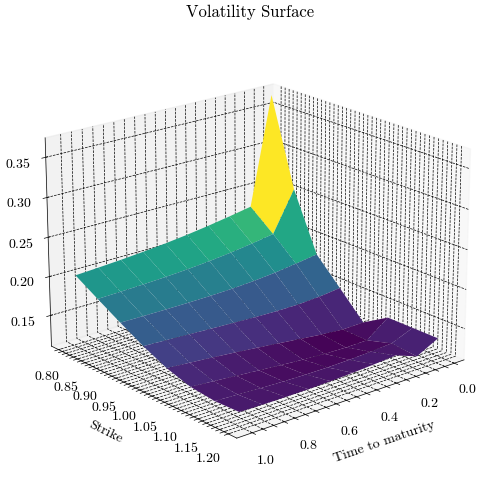

In [24]:
x = np.outer(ttm_grid, np.ones_like(strike_grid))
y = np.outer(strike_grid, np.ones_like(ttm_grid)).T
# generating a figure and a 3D axes
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection="3d")
# plotting the 3D surface plot
ax.plot_surface(x, y, out, cmap="viridis", edgecolor="none")
ax.view_init(20, 50)
plt.xlabel("Time to maturity")
plt.ylabel("Strike")
ax.set_zlabel("Volatility")
plt.title("Volatility Surface")
plt.show()

<div class="alert alert-success">We can see that the COS method produces an implied vol surface almost identical to the Lewis pricing method, except for the points where the Newton-Raphson algorithm does not converge.</div>

In [25]:
eps_range = [0.01, 0.3, 0.5, 1.0]
ttm_grid = np.linspace(0.02, 1, 10)
atm_skew = np.zeros((len(eps_range), len(ttm_grid)))
dK = 1e-6

for i, eps in enumerate(eps_range):
    for j, ttm in enumerate(ttm_grid):
        price1 = put_option_cos(
            s0, ttm, s0 + dK, V0, 1 / eps, rho, 1 / eps, theta, N=2000
        )
        price2 = put_option_cos(
            s0, ttm, s0 - dK, V0, 1 / eps, rho, 1 / eps, theta, N=2000
        )
        vol1 = implied_vol(s0, ttm, s0 + dK, price1)
        vol2 = implied_vol(s0, ttm, s0 - dK, price2)
        atm_skew[i, j] = -s0 * (vol1 - vol2) / (2 * dK)

/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/215276619.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  atm_skew[i, j] = -s0 * (vol1 - vol2) / (2 * dK)


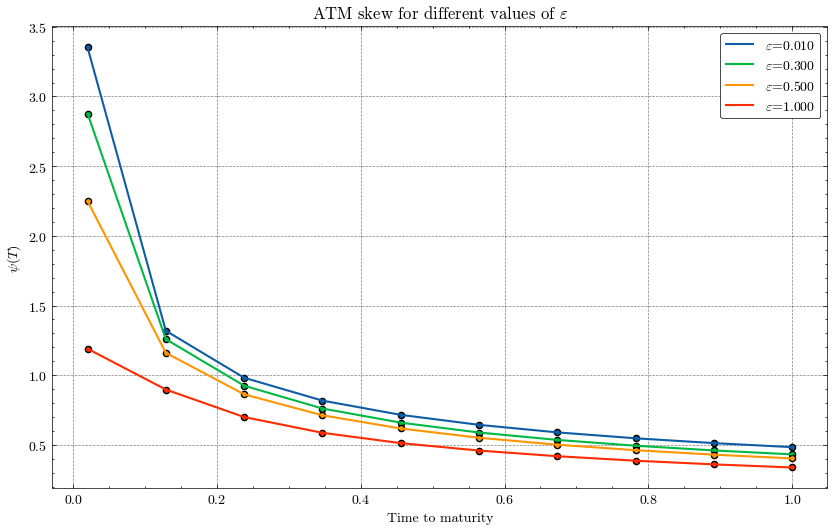

In [26]:
fig = plt.figure(figsize=(10, 6))

for index, eps in enumerate(eps_range):
    plt.plot(ttm_grid, atm_skew[index, :], lw=1.5, label=rf"$\varepsilon$={eps:.3f}")
    plt.scatter(ttm_grid, atm_skew[index, :], marker="o", edgecolors="k", s=20)
legend = plt.legend(
    fancybox=True,
    edgecolor="black",
)
legend.get_frame().set_linewidth(0.5)
plt.title(r"ATM skew for different values of $\varepsilon$")
plt.xlabel("Time to maturity")
plt.ylabel(r"$\psi(T)$")
plt.show()

<div class="alert alert-success">Similarly for the atm skew, the COS method outputs similar results to the Lewis method.</div>

### Monte Carlo Pricing:

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">
The model is as follows: 
\begin{align*}
	dS_t &=S_t \sqrt{V_t} dB_t, \quad d\langle W, B\rangle_t = \rho dt \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW_t, \quad V_0 \geq 0, S_0=1
\end{align*}

In what follows, we use the uniform grid $\left\{t^n_k=\frac{kT}{n}\;;\;k\in\{0,...,n\}\right\}$ over $[0, T]$.

$$\begin{aligned}S_T &= S_0\exp\left(-\frac{1}{2}\int_0^TV_t\,dt + \rho\int_0^T\sqrt{V_t}\,dW_t +\sqrt{1 - \rho^2}\int_0^T\sqrt{V_t}dZ_t\right)\quad\mbox{Where } Z\perp W\\
V_T& = V_0 + \theta T - \kappa \int_{0}^T V_t\,dt + \eta \int_0^T \sqrt{V_t}\,dW_t\end{aligned}$$


 We have $Z \perp W\Longrightarrow V \perp Z\Longrightarrow$. We deduce that:
 $$\sum_{k=0}^n \sqrt{V_{t_i}}\left(Z_{t_{i+1}} - Z_{t_i}\right)\Bigg| \sigma\left(V_t\,,\,t\in[0, T]\right)\sim \mathcal N\left(0, \frac{T}{n}\sum_{k=0}^n V_{t_i}\right)\xrightarrow[n\to\infty]{d}\mathcal N\left(0, \int_0^T V_t \,dt\right)$$
  $$\mbox{Thus: }\quad\int_0^T \sqrt{V_t}\,dZ_t = \lim_{n\to\infty}\sum_{k=0}^n \sqrt{V_{t_i}}\left(Z_{t_{i+1}} - Z_{t_i}\right)\Bigg |\sigma\left(V_t\,,\,t\in[0, T]\right)\sim \mathcal N\left(0, \int_0^T V_t \,dt\right)$$

$$\mbox{And: }\int_0^T\sqrt{V_t}\,dW_t = \frac{1}{\eta}\left(V_T - V_0 - \theta T + \kappa \int_0^T V_t\,dt\right)$$
Finally we can write: 
$$S_T = S_0\exp\left[\left(\frac{\kappa\rho}{\eta} - \frac{1}{2}\right)\int_0^T V_t\,dt + \frac{\rho}{\eta}\left(V_T - V_0 - \theta T\right) + \sqrt{(1-\rho^2)\int_0^T V_t\,dt}\times Z\right]\quad\mbox{Where: } Z\sim \mathcal N(0, 1)\perp V$$
$$P(K, T) = \mathbb E\left[(K - S_T)^+\right] \approx \frac{1}{M}\sum_{i=1}^M (K-S_T^i)^+\quad\mbox{Where: }(S_T^i)_{i\geqslant 0}\stackrel{i.i.d}{\sim} S_T$$</div>

<div class="alert alert-success">For the sampling of $V$ first we use the following naive Euler Scheme called "full truncation":
$$V_{t_{k+1}} = V_{t_k} + (\theta - \kappa V_{t_k}^+)\frac{T}{n} + \eta\sqrt{\frac{T}{n}V_{t_k}^+} \times W_{k+1}$$
This scheme is called "full truncation" since the process $V$ becomes deterministic after going below the origin.
We approximate the path integral via the trapezoid method, i.e:
$$\int_0^T V_t\,dt \approx\frac{T}{n}\sum_{k=0}^{n-1}\frac{V_{t_{k+1}} + V_{t_k}}{2}$$</div>

In [30]:
def full_truncation(
    random_sample: np.ndarray,
    ttm: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
) -> np.ndarray:
    m, n = random_sample.shape
    delta = ttm / n
    sample_path = np.zeros((m, (n + 1)))
    sample_path[0] = var
    for i in range(n):
        sample_path[:, i + 1] = (
            sample_path[:, i]
            + (theta - kappa * np.maximum(sample_path[:, i], 0)) * delta
            + eta
            * np.sqrt(delta * np.maximum(sample_path[:, i], 0))
            * random_sample[:, i]
        )

    return np.maximum(sample_path, 0)

In [387]:
def sample_spot(
    normal_sample: np.ndarray,
    variance: np.ndarray,
    spot: float,
    ttm: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
) -> np.ndarray:
    path_integral = ttm * np.mean(variance[:, :-1] + variance[:, 1:], axis=1) / 2

    return spot * np.exp(
        (kappa * rho / eta - 1 / 2) * path_integral
        + rho / eta * (variance[:, -1] - var - theta * ttm)
        + np.sqrt((1 - rho**2) * path_integral) * normal_sample
    )

In [295]:
# Sanity check:
k_list = np.arange(13, 21)
M_list = np.array([int(2**k) for k in k_list])
n = 100
mc_results_1y = np.zeros((len(k_list), 3))
mc_results_10y = np.zeros((len(k_list), 3))
confidence_level = 0.05
q = norm.ppf(1 - confidence_level / 2)
for i, M in enumerate(M_list):
    random_sample = rng.standard_normal((M, n))
    normal_sample = rng.standard_normal(M)
    variance_1y = full_truncation(random_sample, 1, **model)
    sample_spot_1y = sample_spot(normal_sample, variance_1y, s0, 1, **model)
    payoff_1y = np.maximum(K - sample_spot_1y, 0)
    mc_results_1y[i, 0] = payoff_1y.mean()
    mc_results_1y[i, 1] = q * payoff_1y.std() / np.sqrt(M)
    mc_results_1y[i, 2] = len(payoff_1y[payoff_1y == 0]) / len(payoff_1y)
    variance_10y = full_truncation(random_sample, 10, **model)
    sample_spot_10y = sample_spot(normal_sample, variance_10y, s0, 10, **model)
    payoff_10y = np.maximum(K - sample_spot_10y, 0)
    mc_results_10y[i, 0] = payoff_10y.mean()
    mc_results_10y[i, 1] = q * payoff_10y.std() / np.sqrt(M)
    mc_results_10y[i, 2] = len(payoff_10y[payoff_10y == 0]) / len(payoff_10y)

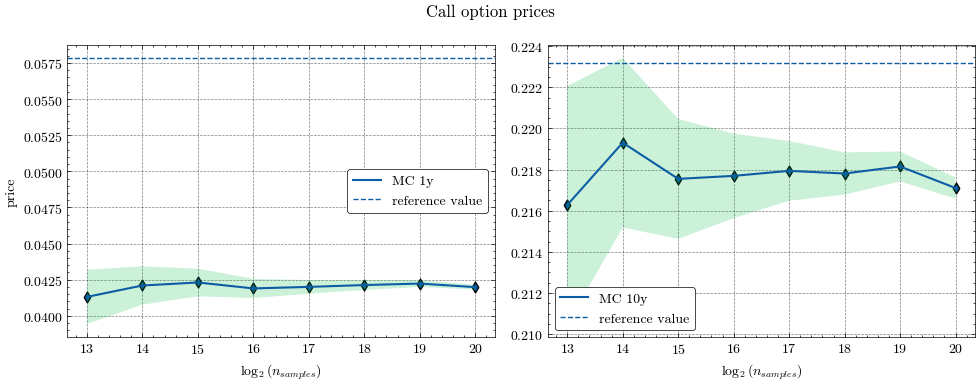

In [296]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(k_list, mc_results_1y[:, 0], lw=1.5, label="MC 1y")
ax1.scatter(k_list, mc_results_1y[:, 0], marker="d", edgecolor="k", s=30)
ax1.fill_between(
    k_list,
    mc_results_1y[:, 0] - mc_results_1y[:, 1],
    mc_results_1y[:, 0] + mc_results_1y[:, 1],
    alpha=0.2,
)
ax1.axhline(y=ref_value_T1y, linestyle="--", label="reference value")
ax1.set_xlabel(r"$\log_2(n_{samples})$")
ax1.set_ylabel("price")
ax1_legend = ax1.legend(fancybox=True, edgecolor="black", loc=0)
ax1_legend.get_frame().set_linewidth(0.5)

ax2.plot(k_list, mc_results_10y[:, 0], lw=1.5, label="MC 10y")
ax2.scatter(k_list, mc_results_10y[:, 0], marker="d", edgecolor="k", s=30)
ax2.fill_between(
    k_list,
    mc_results_10y[:, 0] - mc_results_10y[:, 1],
    mc_results_10y[:, 0] + mc_results_10y[:, 1],
    alpha=0.2,
)
ax2.axhline(y=ref_value_T10y, linestyle="--", label="reference value")
ax2.set_xlabel(r"$\log_2(n_{samples})$")
ax2_legend = ax2.legend(fancybox=True, edgecolor="black", loc=0)
ax2_legend.get_frame().set_linewidth(0.5)
fig.suptitle("Call option prices")
fig.tight_layout()
plt.show()
plt.close()

<div class="alert alert-danger">There is considerable bias in the monte carlo prices obtained, this is perhaps due to the fact that alot of the payoffs that our scheme produces are zero, as illustrated below.</div>

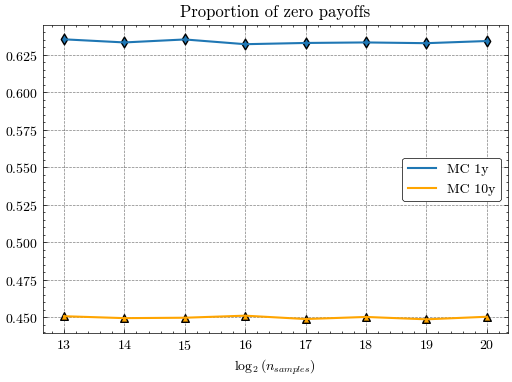

In [298]:
fig = plt.figure(figsize=(6, 4))
plt.plot(k_list, mc_results_1y[:, 2], color="tab:blue", lw=1.5, label="MC 1y")
plt.scatter(
    k_list, mc_results_1y[:, 2], color="tab:blue", marker="d", edgecolor="k", s=30
)
plt.plot(k_list, mc_results_10y[:, 2], color="orange", lw=1.5, label="MC 10y")
plt.scatter(
    k_list, mc_results_10y[:, 2], color="orange", marker="^", edgecolor="k", s=30
)
legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.xlabel(r"$\log_2(n_{samples})$")
plt.title("Proportion of zero payoffs")
plt.show()
plt.close()

<div class="alert alert-success">To remedy this issue, one could resort to importance sampling. Per the article <a href="https://lup.lub.lu.se/luur/download?func=downloadFile&recordOId=8408338&fileOId=8408354">A comparison of the Fourier-Gauss-Laguerre and Fourier cosine series
method in option pricing</a>, if we choose a new measure $\tilde{\mathbb Q}$ such that :
    \begin{align*}
	dS_t &= aS_tdt + S_t \sqrt{V_t}\left(\rho dW^{\tilde{\mathbb Q}}_t + \sqrt{1-\rho^2} dZ^{\tilde{\mathbb Q}}_t\right), \quad W^{\tilde{\mathbb Q}} \perp Z^{\tilde{\mathbb Q}} \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW^{\tilde{\mathbb Q}}_t, \quad V_0 \geq 0, S_0=1
\end{align*}
Than the girsanov kernel $g$ should satisfy : $a - \left(\rho\sqrt{V_t}, \sqrt{1-\rho^2}\sqrt{V_t}\right)g(t) = 0$. Where :
    $$\frac{d\tilde{\mathbb Q}}{d\mathbb Q} = L = \exp \left(-\frac{1}{2}\int_0^T \left|g(t)\right|^2\,dt - \int_0^T \left(dZ^{\tilde{\mathbb Q}}_t, dW^{\tilde{\mathbb Q}}_t \right) g(t)\right)$$
    We take $g(t) = \left(\frac{a}{\sqrt{1-\rho^2}\sqrt{V_t}}, 0\right)^\top$, which leads to :
    $$ L = \exp\left(-\frac{1}{2}\int_0^T\frac{a^2}{(1-\rho^2)V_t}\,dt - \int_0^T \frac{a}{\sqrt{1-\rho^2}\sqrt{V_t}}\,dZ^{\tilde{\mathbb Q}}_t\right)$$ 
    It is mentioned that we further reduce variance if we choose :
    $$ \tilde L = \mathbb E ^{\tilde{\mathbb Q}}\left[L\,|\left\{V_t\,;\, 0\leqslant t\leqslant T\right\}, S_T\right] = \exp\left(-\frac{(aT)^2}{2(1-\rho^2)\int_0^T V_t\,dt} - \frac{aT}{\sqrt{1-\rho^2}\sqrt{\int_0^T V_t\,dt}}Z\right)\quad\mbox{Where: } Z\sim \mathcal N(0, 1)\perp V$$
    The article suggests that the choice $a=\frac{\log(K/S_0)}{2T}$ produces the best results.
</div>

In [373]:
def is_sample_spot(
    normal_sample: np.ndarray,
    variance: np.ndarray,
    spot: float,
    ttm: float,
    a: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
) -> np.ndarray:
    path_integral = ttm * np.mean(variance[:, :-1] + variance[:, 1:], axis=1) / 2
    L = np.exp(
        -((a * ttm) ** 2) / (2 * (1 - rho**2) * path_integral)
        - a * ttm * normal_sample / np.sqrt((1 - rho**2) * path_integral)
    )
    sample_path = spot * np.exp(
        a * ttm
        + (kappa * rho / eta - 1 / 2) * path_integral
        + rho / eta * (variance[:, -1] - var - theta * ttm)
        + np.sqrt((1 - rho**2) * path_integral) * normal_sample
    )
    return sample_path, L

In [326]:
# Sanity check:
k_list = np.arange(13, 21)
M_list = np.array([int(2**k) for k in k_list])
n = 100
mc_results_1y = np.zeros((len(k_list), 3))
mc_results_10y = np.zeros((len(k_list), 3))
confidence_level = 0.05
q = norm.ppf(1 - confidence_level / 2)
for i, M in enumerate(M_list):
    random_sample = rng.standard_normal((M, n))
    normal_sample = rng.standard_normal(M)
    a = -0.5
    variance_1y = full_truncation(random_sample, 1, **model)
    sample_spot_1y, L_1y = is_sample_spot(normal_sample, variance_1y, s0, 1, a, **model)
    payoff_1y = np.maximum(K - sample_spot_1y, 0) * L_1y
    mc_results_1y[i, 0] = payoff_1y.mean()
    mc_results_1y[i, 1] = q * payoff_1y.std() / np.sqrt(M)
    mc_results_1y[i, 2] = len(payoff_1y[payoff_1y == 0]) / len(payoff_1y)
    variance_10y = full_truncation(random_sample, 10, **model)
    a = -1 / 30
    sample_spot_10y, L_10y = is_sample_spot(
        normal_sample, variance_10y, s0, 10, a, **model
    )
    payoff_10y = np.maximum(K - sample_spot_10y, 0) * L_10y
    mc_results_10y[i, 0] = payoff_10y.mean()
    mc_results_10y[i, 1] = q * payoff_10y.std() / np.sqrt(M)
    mc_results_10y[i, 2] = len(payoff_10y[payoff_10y == 0]) / len(payoff_10y)

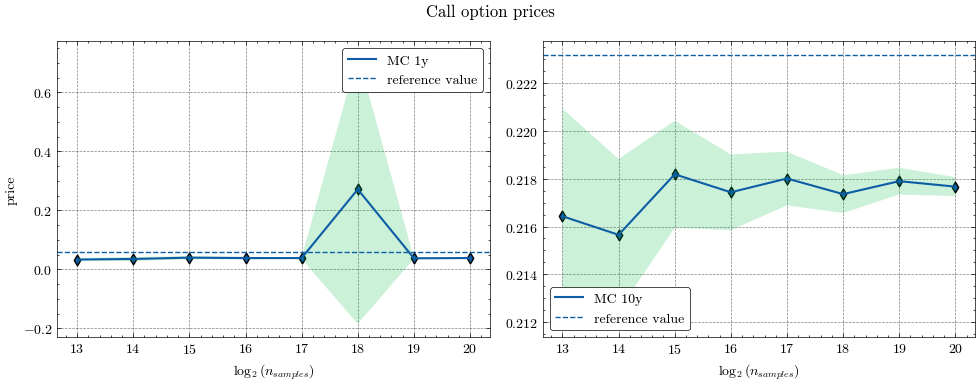

In [327]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(k_list, mc_results_1y[:, 0], lw=1.5, label="MC 1y")
ax1.scatter(k_list, mc_results_1y[:, 0], marker="d", edgecolor="k", s=30)
ax1.fill_between(
    k_list,
    mc_results_1y[:, 0] - mc_results_1y[:, 1],
    mc_results_1y[:, 0] + mc_results_1y[:, 1],
    alpha=0.2,
)
ax1.axhline(y=ref_value_T1y, linestyle="--", label="reference value")
ax1.set_xlabel(r"$\log_2(n_{samples})$")
ax1.set_ylabel("price")
ax1_legend = ax1.legend(fancybox=True, edgecolor="black", loc=0)
ax1_legend.get_frame().set_linewidth(0.5)

ax2.plot(k_list, mc_results_10y[:, 0], lw=1.5, label="MC 10y")
ax2.scatter(k_list, mc_results_10y[:, 0], marker="d", edgecolor="k", s=30)
ax2.fill_between(
    k_list,
    mc_results_10y[:, 0] - mc_results_10y[:, 1],
    mc_results_10y[:, 0] + mc_results_10y[:, 1],
    alpha=0.2,
)
ax2.axhline(y=ref_value_T10y, linestyle="--", label="reference value")
ax2.set_xlabel(r"$\log_2(n_{samples})$")
ax2_legend = ax2.legend(fancybox=True, edgecolor="black", loc=0)
ax2_legend.get_frame().set_linewidth(0.5)
fig.suptitle("Call option prices")
fig.tight_layout()
plt.show()
plt.close()

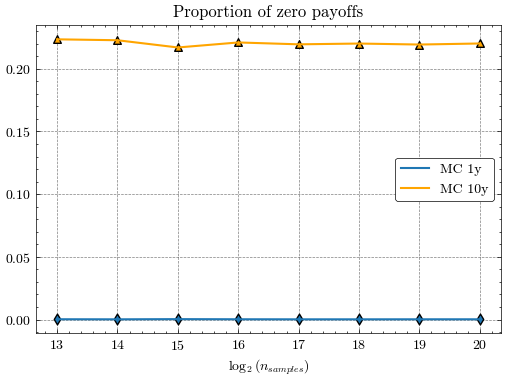

In [329]:
fig = plt.figure(figsize=(6, 4))
plt.plot(k_list, mc_results_1y[:, 2], color="tab:blue", lw=1.5, label="MC 1y")
plt.scatter(
    k_list, mc_results_1y[:, 2], color="tab:blue", marker="d", edgecolor="k", s=30
)
plt.plot(k_list, mc_results_10y[:, 2], color="orange", lw=1.5, label="MC 10y")
plt.scatter(
    k_list, mc_results_10y[:, 2], color="orange", marker="^", edgecolor="k", s=30
)
legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.xlabel(r"$\log_2(n_{samples})$")
plt.title("Proportion of zero payoffs")
plt.show()
plt.close()

<div class="alert alert-warning">We managed to reduce the number of zero payoffs via importance sampling, but the results remain unsatisfactory </div>

<div class="alert alert-success">An important propriety of the model is that for $u < t$:
$$V_t\,\Big | \,V_u\sim \frac{\eta^2\left(1 - e^{-\kappa(t-u)}\right)}{4\kappa}\chi'_{d}\left(\frac{4\kappa e^{-\kappa(t-u)}}{\eta^2\left(1 - e^{-\kappa(t-u)}\right)}V_u\right)\quad \mbox{Where: } d = \frac{4\theta}{\eta^2}$$

Where $\chi'^2_{d}$ is a non-centered chi square distribution with $d$-degrees of freedom. We also know that for $N\sim Poisson\left(\frac{\lambda}{2}\right)$ then $\chi^2_{d+2N}$ has the same distribution as $\chi'^2_{d}(\lambda)$.
We can thus "exactly" sample each $V_{t_k}$, but this is very time costly.
Let's try now exact sampling of the discretisation of $V$.</div>

In [343]:
def exact_sampling(
    n: int,
    ttm: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
) -> np.ndarray:
    delta = ttm / n
    d = 4 * theta / eta**2
    c = eta**2 * (1 - np.exp(-kappa * delta)) / (4 * kappa)
    lamda = np.exp(-kappa * delta) / c
    sample_path = np.zeros(n + 1)
    sample_path[0] = var
    for i in range(n):
        poisson_sample = rng.poisson(lam=lamda * sample_path[i] / 2)
        sample_path[i + 1] = c * rng.chisquare(d + 2 * poisson_sample)

    return sample_path

In [355]:
# Sanity check:
k_list = np.arange(10, 18)
M_list = np.array([int(2**k) for k in k_list])
n = 100
mc_results_1y = np.zeros((len(k_list), 3))
mc_results_10y = np.zeros((len(k_list), 3))
confidence_level = 0.05
q = norm.ppf(1 - confidence_level / 2)
for i in tqdm(range(len(M_list))):
    M = M_list[i]
    normal_sample = rng.standard_normal(M)
    variance_1y = np.zeros((M, n + 1))
    for j in range(M):
        variance_1y[j, :] = exact_sampling(n, 1, **model)
    sample_spot_1y = sample_spot(normal_sample, variance_1y, s0, 1, **model)
    payoff_1y = np.maximum(K - sample_spot_1y, 0)
    mc_results_1y[i, 0] = payoff_1y.mean()
    mc_results_1y[i, 1] = q * payoff_1y.std() / np.sqrt(M)
    mc_results_1y[i, 2] = len(payoff_1y[payoff_1y == 0]) / len(payoff_1y)
    variance_10y = np.zeros((M, n + 1))
    for j in range(M):
        variance_10y[j, :] = exact_sampling(n, 10, **model)
    sample_spot_10y = sample_spot(normal_sample, variance_10y, s0, 10, **model)
    payoff_10y = np.maximum(K - sample_spot_10y, 0)
    mc_results_10y[i, 0] = payoff_10y.mean()
    mc_results_10y[i, 1] = q * payoff_10y.std() / np.sqrt(M)
    mc_results_10y[i, 2] = len(payoff_10y[payoff_10y == 0]) / len(payoff_10y)

100%|█████████████████████████████████████████████| 8/8 [00:36<00:00,  4.59s/it]


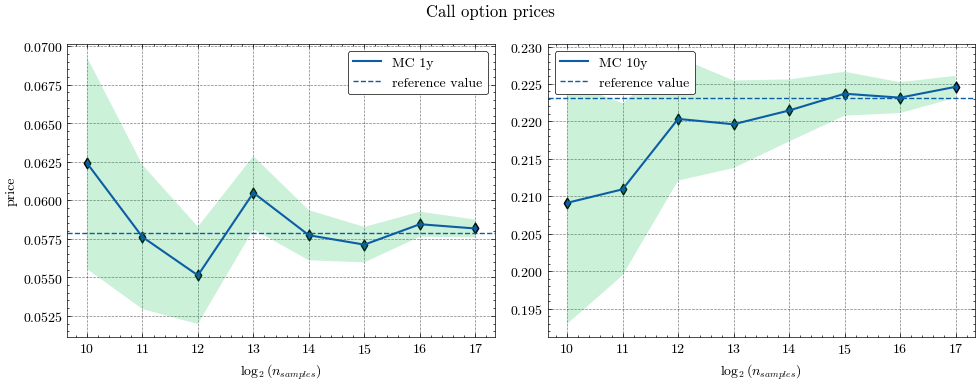

In [356]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(k_list, mc_results_1y[:, 0], lw=1.5, label="MC 1y")
ax1.scatter(k_list, mc_results_1y[:, 0], marker="d", edgecolor="k", s=30)
ax1.fill_between(
    k_list,
    mc_results_1y[:, 0] - mc_results_1y[:, 1],
    mc_results_1y[:, 0] + mc_results_1y[:, 1],
    alpha=0.2,
)
ax1.axhline(y=ref_value_T1y, linestyle="--", label="reference value")
ax1.set_xlabel(r"$\log_2(n_{samples})$")
ax1.set_ylabel("price")
ax1_legend = ax1.legend(fancybox=True, edgecolor="black", loc=0)
ax1_legend.get_frame().set_linewidth(0.5)

ax2.plot(k_list, mc_results_10y[:, 0], lw=1.5, label="MC 10y")
ax2.scatter(k_list, mc_results_10y[:, 0], marker="d", edgecolor="k", s=30)
ax2.fill_between(
    k_list,
    mc_results_10y[:, 0] - mc_results_10y[:, 1],
    mc_results_10y[:, 0] + mc_results_10y[:, 1],
    alpha=0.2,
)
ax2.axhline(y=ref_value_T10y, linestyle="--", label="reference value")
ax2.set_xlabel(r"$\log_2(n_{samples})$")
ax2_legend = ax2.legend(fancybox=True, edgecolor="black", loc=0)
ax2_legend.get_frame().set_linewidth(0.5)
fig.suptitle("Call option prices")
fig.tight_layout()
plt.show()
plt.close()

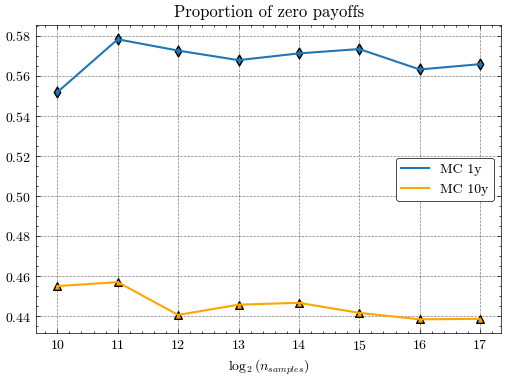

In [357]:
fig = plt.figure(figsize=(6, 4))
plt.plot(k_list, mc_results_1y[:, 2], color="tab:blue", lw=1.5, label="MC 1y")
plt.scatter(
    k_list, mc_results_1y[:, 2], color="tab:blue", marker="d", edgecolor="k", s=30
)
plt.plot(k_list, mc_results_10y[:, 2], color="orange", lw=1.5, label="MC 10y")
plt.scatter(
    k_list, mc_results_10y[:, 2], color="orange", marker="^", edgecolor="k", s=30
)
legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.xlabel(r"$\log_2(n_{samples})$")
plt.title("Proportion of zero payoffs")
plt.show()
plt.close()

<div class="alert alert-success"> Results are much better as expected since our monte carlo estimators are able to converge with an even lower number of samples than before. We will attempt to further reduce variance by combining antithetic and importance sampling.</div>

In [374]:
def is_antithetic_sample_spot(
    normal_sample: np.ndarray,
    variance: np.ndarray,
    spot: float,
    ttm: float,
    a: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
) -> np.ndarray:
    path_integral = ttm * np.mean(variance[:, :-1] + variance[:, 1:], axis=1) / 2
    L = np.exp(
        -((a * ttm) ** 2) / (2 * (1 - rho**2) * path_integral)
        - a * ttm * normal_sample / np.sqrt((1 - rho**2) * path_integral)
    )
    antithetic_L = np.exp(
        -((a * ttm) ** 2) / (2 * (1 - rho**2) * path_integral)
        + a * ttm * normal_sample / np.sqrt((1 - rho**2) * path_integral)
    )
    sample_path = spot * np.exp(
        a * ttm
        + (kappa * rho / eta - 1 / 2) * path_integral
        + rho / eta * (variance[:, -1] - var - theta * ttm)
        + np.sqrt((1 - rho**2) * path_integral) * normal_sample
    )
    antithetic_path = spot * np.exp(
        a * ttm
        + (kappa * rho / eta - 1 / 2) * path_integral
        + rho / eta * (variance[:, -1] - var - theta * ttm)
        - np.sqrt((1 - rho**2) * path_integral) * normal_sample
    )
    return sample_path, antithetic_path, L, antithetic_L

In [381]:
# Sanity check:
k_list = np.arange(10, 18)
M_list = np.array([int(2**k) for k in k_list])
n = 100
mc_results_1y = np.zeros((len(k_list), 3))
mc_results_10y = np.zeros((len(k_list), 3))
confidence_level = 0.05
q = norm.ppf(1 - confidence_level / 2)
for i in tqdm(range(len(M_list))):
    M = M_list[i]
    normal_sample = rng.standard_normal(M)
    variance_1y = np.zeros((M, n + 1))
    for j in range(M):
        variance_1y[j, :] = exact_sampling(n, 1, **model)
    (
        sample_spot_1y,
        antithetic_sample_spot_1y,
        L_1y,
        antithetic_L_1y,
    ) = is_antithetic_sample_spot(normal_sample, variance_1y, s0, 1, 0, **model)
    payoff_1y = (
        np.maximum(K - sample_spot_1y, 0) * L_1y
        + np.maximum(K - antithetic_sample_spot_1y, 0) * antithetic_L_1y
    ) / 2
    mc_results_1y[i, 0] = payoff_1y.mean()
    mc_results_1y[i, 1] = q * payoff_1y.std() / np.sqrt(M)
    mc_results_1y[i, 2] = len(payoff_1y[payoff_1y == 0]) / len(payoff_1y)
    variance_10y = np.zeros((M, n + 1))
    for j in range(M):
        variance_10y[j, :] = exact_sampling(n, 10, **model)
    (
        sample_spot_10y,
        antithetic_sample_spot_10y,
        L_10y,
        antithetic_L_10y,
    ) = is_antithetic_sample_spot(normal_sample, variance_10y, s0, 10, 0, **model)
    payoff_10y = (
        np.maximum(K - sample_spot_10y, 0) * L_10y
        + np.maximum(K - antithetic_sample_spot_10y, 0) * antithetic_L_10y
    ) / 2
    mc_results_10y[i, 0] = payoff_10y.mean()
    mc_results_10y[i, 1] = q * payoff_10y.std() / np.sqrt(M)
    mc_results_10y[i, 2] = len(payoff_10y[payoff_10y == 0]) / len(payoff_10y)

100%|█████████████████████████████████████████████| 8/8 [00:36<00:00,  4.60s/it]


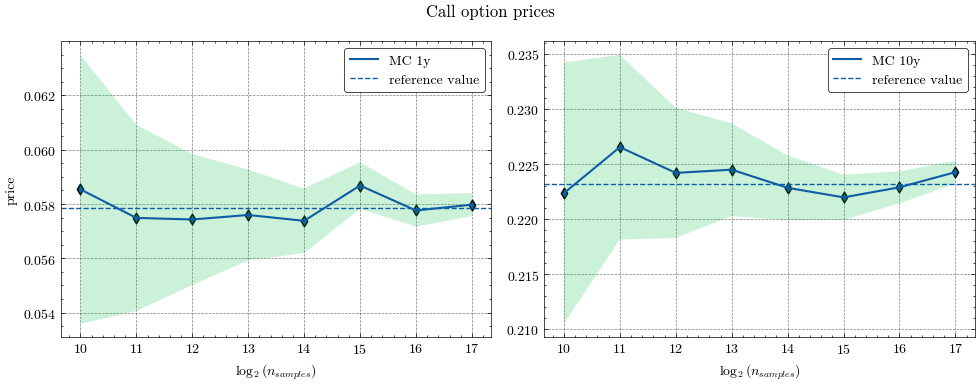

In [382]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(k_list, mc_results_1y[:, 0], lw=1.5, label="MC 1y")
ax1.scatter(k_list, mc_results_1y[:, 0], marker="d", edgecolor="k", s=30)
ax1.fill_between(
    k_list,
    mc_results_1y[:, 0] - mc_results_1y[:, 1],
    mc_results_1y[:, 0] + mc_results_1y[:, 1],
    alpha=0.2,
)
ax1.axhline(y=ref_value_T1y, linestyle="--", label="reference value")
ax1.set_xlabel(r"$\log_2(n_{samples})$")
ax1.set_ylabel("price")
ax1_legend = ax1.legend(fancybox=True, edgecolor="black", loc=0)
ax1_legend.get_frame().set_linewidth(0.5)

ax2.plot(k_list, mc_results_10y[:, 0], lw=1.5, label="MC 10y")
ax2.scatter(k_list, mc_results_10y[:, 0], marker="d", edgecolor="k", s=30)
ax2.fill_between(
    k_list,
    mc_results_10y[:, 0] - mc_results_10y[:, 1],
    mc_results_10y[:, 0] + mc_results_10y[:, 1],
    alpha=0.2,
)
ax2.axhline(y=ref_value_T10y, linestyle="--", label="reference value")
ax2.set_xlabel(r"$\log_2(n_{samples})$")
ax2_legend = ax2.legend(fancybox=True, edgecolor="black", loc=0)
ax2_legend.get_frame().set_linewidth(0.5)
fig.suptitle("Call option prices")
fig.tight_layout()
plt.show()
plt.close()

In [391]:
# Sanity check:
k_list = np.arange(10, 18)
M_list = np.array([int(2**k) for k in k_list])
n = 100
mc_results_1y = np.zeros((len(k_list)))
antithetic_mc_results_1y = np.zeros((len(k_list)))
mc_results_10y = np.zeros((len(k_list)))
antithetic_mc_results_10y = np.zeros((len(k_list)))
confidence_level = 0.05
q = norm.ppf(1 - confidence_level / 2)
for i in tqdm(range(len(M_list))):
    M = M_list[i]
    normal_sample = rng.standard_normal(M)
    antithetic_normal_sample = rng.standard_normal(int(M / 2))
    variance_1y = np.zeros((M, n + 1))
    antithetic_variance_1y = np.zeros((int(M / 2), n + 1))
    for j in range(M):
        variance_1y[j, :] = exact_sampling(n, 1, **model)

    for j in range(int(M / 2)):
        antithetic_variance_1y[j, :] = exact_sampling(n, 1, **model)

        (
            sample_spot_1y,
            antithetic_sample_spot_1y,
            L_1y,
            antithetic_L_1y,
        ) = is_antithetic_sample_spot(
            antithetic_normal_sample, antithetic_variance_1y, s0, 1, 0, **model
        )
    antithetic_payoff_1y = (
        np.maximum(K - sample_spot_1y, 0) * L_1y
        + np.maximum(K - antithetic_sample_spot_1y, 0) * antithetic_L_1y
    ) / 2
    antithetic_mc_results_1y[i] = q * antithetic_payoff_1y.std() / np.sqrt(M / 2)
    sample_spot_1y = sample_spot(normal_sample, variance_1y, s0, 1, **model)
    payoff_1y = np.maximum(K - sample_spot_1y, 0)
    mc_results_1y[i] = q * payoff_1y.std() / np.sqrt(M)
    variance_10y = np.zeros((M, n + 1))
    antithetic_variance_10y = np.zeros((int(M / 2), n + 1))
    for j in range(M):
        variance_10y[j, :] = exact_sampling(n, 10, **model)

    for j in range(int(M / 2)):
        antithetic_variance_10y[j, :] = exact_sampling(n, 1, **model)

        (
            sample_spot_10y,
            antithetic_sample_spot_10y,
            L_10y,
            antithetic_L_10y,
        ) = is_antithetic_sample_spot(
            antithetic_normal_sample, antithetic_variance_10y, s0, 10, 0, **model
        )
    antithetic_payoff_10y = (
        np.maximum(K - sample_spot_10y, 0) * L_10y
        + np.maximum(K - antithetic_sample_spot_10y, 0) * antithetic_L_10y
    ) / 2
    antithetic_mc_results_10y[i] = q * antithetic_payoff_10y.std() / np.sqrt(M / 2)
    sample_spot_10y = sample_spot(normal_sample, variance_10y, s0, 10, **model)
    payoff_10y = np.maximum(K - sample_spot_10y, 0)
    mc_results_10y[i] = q * payoff_10y.std() / np.sqrt(M)

  0%|                                                     | 0/8 [00:00<?, ?it/s]/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_61758/3667948326.py:15: RuntimeWarning: invalid value encountered in divide
  -((a * ttm) ** 2) / (2 * (1 - rho**2) * path_integral)
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_61758/3667948326.py:16: RuntimeWarning: invalid value encountered in divide
  - a * ttm * normal_sample / np.sqrt((1 - rho**2) * path_integral)
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_61758/3667948326.py:19: RuntimeWarning: invalid value encountered in divide
  -((a * ttm) ** 2) / (2 * (1 - rho**2) * path_integral)
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_61758/3667948326.py:20: RuntimeWarning: invalid value encountered in divide
  + a * ttm * normal_sample / np.sqrt((1 - rho**2) * path_integral)
100%|████████████████████████████████████████████| 8/8 [29:58<00:00, 224.85s/it]


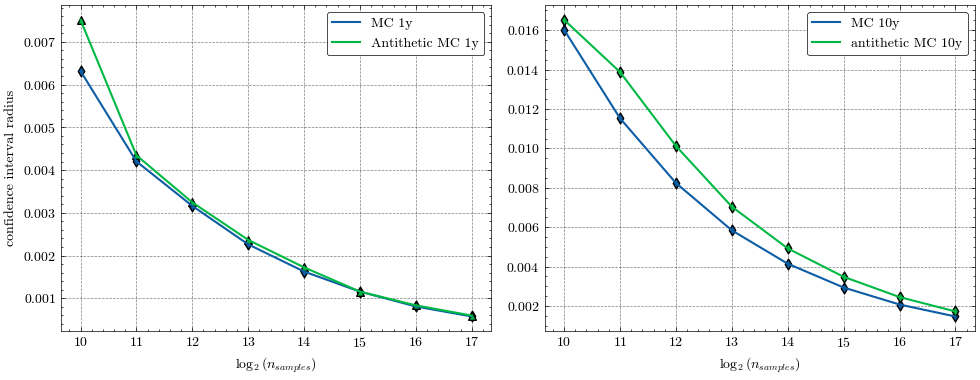

In [395]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.plot(k_list, mc_results_1y, lw=1.5, label="MC 1y")
ax1.scatter(k_list, mc_results_1y, marker="d", edgecolor="k", s=30)
ax1.plot(k_list, antithetic_mc_results_1y, lw=1.5, label="Antithetic MC 1y")
ax1.scatter(k_list, antithetic_mc_results_1y, marker="^", edgecolor="k", s=30)

ax1.set_xlabel(r"$\log_2(n_{samples})$")
ax1.set_ylabel("confidence interval radius")
ax1_legend = ax1.legend(fancybox=True, edgecolor="black", loc=0)
ax1_legend.get_frame().set_linewidth(0.5)

ax2.plot(k_list, mc_results_10y, lw=1.5, label="MC 10y")
ax2.scatter(k_list, mc_results_10y, marker="d", edgecolor="k", s=30)
ax2.plot(k_list, antithetic_mc_results_10y, lw=1.5, label="antithetic MC 10y")
ax2.scatter(k_list, antithetic_mc_results_10y, marker="d", edgecolor="k", s=30)

ax2.set_xlabel(r"$\log_2(n_{samples})$")
ax2_legend = ax2.legend(fancybox=True, edgecolor="black", loc=0)
ax2_legend.get_frame().set_linewidth(0.5)
fig.tight_layout()
plt.show()
plt.close()

<div class="alert alert-success"> We can see that the antithetic monte carlo estimator has the same variance as the naive monte carlo estimator for half the number of samples. We chose to divide the number of samples used in the antithetic estimator by half for the two estimators to be comparable from a computational point of view. But this result is actually very good since the bottlneck in our simulation is the exact sampling of $V$ and not the computation of the payoff. There is thus no real computational downside to the antithetic estimator while maintaining lower variance than the naive estimator.</div>

In [396]:
strike_grid = np.linspace(0.8, 1.2, 8)
ttm_grid = np.linspace(0.02, 1, 10)
vol_surface = np.zeros((len(ttm_grid), len(strike_grid)))
errors = np.zeros((len(ttm_grid), len(strike_grid)))
M = int(2**16)
n = 100

for i, ttm in enumerate(ttm_grid):
    for j, strike in enumerate(strike_grid):
        a = np.log(s0 / strike) / (2 * ttm)
        normal_sample = rng.standard_normal(M)
        variance = np.zeros((M, n + 1))
        for k in range(M):
            variance[k, :] = exact_sampling(n, ttm, **model)
        (
            sample_spot,
            antithetic_sample_spot,
            L,
            antithetic_L,
        ) = is_antithetic_sample_spot(normal_sample, variance, s0, ttm, a, **model)
        payoff = (
            np.maximum(strike - sample_spot, 0) * L
            + np.maximum(strike - antithetic_sample_spot, 0) * antithetic_L
        ) / 2
        model_price = payoff.mean()
        vol_surface[i, j] = implied_vol(s0, ttm, strike, model_price)
        errors[i, j] = np.abs(
            s0 - strike + model_price - bs_price(s0, ttm, strike, vol_surface[i, j])
        )

/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_61758/1826780129.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  vol += (price - bs_price) / (vega)
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_61758/1826780129.py:29: RuntimeWarning: invalid value encountered in double_scalars
  d2 = d1 - np.sqrt(ttm) * vol


In [412]:
mask = np.isnan(vol_surface)
idx = np.where(~mask, np.arange(mask.shape[1]), 0)
np.maximum.accumulate(idx, axis=1, out=idx)
out = vol_surface[np.arange(idx.shape[0])[:, None], idx]

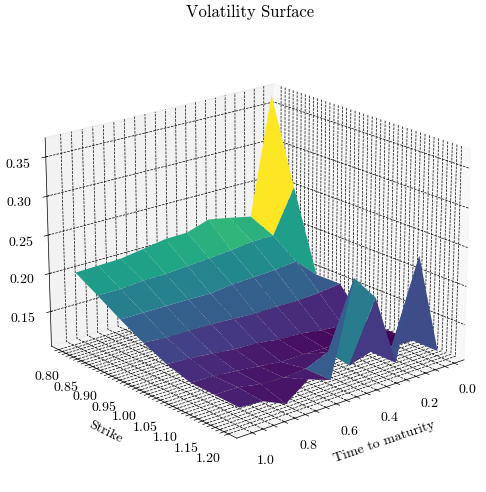

In [414]:
x = np.outer(ttm_grid, np.ones_like(strike_grid))
y = np.outer(strike_grid, np.ones_like(ttm_grid)).T
# generating a figure and a 3D axes
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection="3d")
# plotting the 3D surface plot
ax.plot_surface(x, y, out, cmap="viridis", edgecolor="none")
ax.view_init(20, 50)
plt.xlabel("Time to maturity")
plt.ylabel("Strike")
ax.set_zlabel("Volatility")
plt.title("Volatility Surface")
plt.show()

<div class="alert alert-warning"> The volatility surface obtained via monte carlo is slightly unstable due to the uncertainty and our compuntational limitations. But either way it remains very similar to what we manage to obtain before, except for the out of the money points that do not converge similarly to the COS method</div>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2. Volterra Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong>  </strong></p>

1. Do the same thing for Volterra Heston model:
Heston by a fractional one:
\begin{align*}
	dS_t &= S_t \sqrt{V_t} dB_t, \quad S_0=1,\\
	V_t &= V_0 + \int_0^t   K_{\epsilon}(t-s) \left(  ( \theta - \kappa V_s) ds +  \eta  \sqrt{V_s} dW_s \right),
\end{align*}
with $K_{\epsilon}(t) = {{(t +\epsilon)}^{H-1/2}}$

by implementing the Adam Scheme (or any other scheme) for the Riccati Volterra equation

2.  Plot the volatility surface for with $T=\{0.02, 0.04, 0.1, 0.25, 0.5, 1. \}$
and parameters 
\begin{equation}
 \kappa = 0, \quad    \rho=-0.7, \quad \theta=0.02, \quad \eta=0.3, \quad V_0=0.02, \quad H=0.1.
\end{equation}

3. For fixed $\epsilon =0$, make $H$ vary and plot the atm-skew between 1 week and 1 year for varying $H$ and comment
4. For fixed $H=0.01$ make $\epsilon$ vary and plot the atm-skew between 1 week and 1 year  and comment. 
5. Which model seems more suited for the market? argue. 
 

 <div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">
The characteristic function of the rough heston model can be expressed as follows:
     $$\mathbb E\left[e^{iu\log(S_T)}\right] = \exp\left(iu\log(S_0) + \int_0^T F(\psi)(T-t)g_0(t)\,dt\right)$$ 

$$ \mbox{Where : }g_0(t) = V_0 + \theta\int_0^t K_\varepsilon(t-s)\,ds\quad \mbox{and : } \psi(t) = \int_0^t K_\epsilon (t-s)F(\psi)(s)\,ds$$
$$ F(\psi) = -\frac{u^2 + iu}{2}  + (u\rho\eta - \kappa)\psi  + \frac{\eta^2}{2}\psi^2$$ 
$$ \int_0^T F(\psi)(T-t)g_0(t)\,dt = V_0 \int_0^TF(\psi)(t)\,dt + \theta\int_0^T\int_0^tF(\psi)(T-t)K_\varepsilon(t-s)\,ds\,dt$$
 $$\begin{aligned}\int_0^T\int_0^tF(\psi)(T-t)K_\varepsilon(t-s)\,ds\,dt& = \int_0^T\int_0^TF(\psi)(T-t)K_\varepsilon(t-s)1_{s\leqslant t}\,ds\,dt\\
 &= \int_0^T\int_s^TF(\psi)(T-t)K_\varepsilon(t-s)\,dt\,ds \\
 &=\int_0^T\int_0^{T-s}F(\psi)(T- s -u)K_\varepsilon(u)\,du\,ds\\
 &= \int_0^T\int_0^{T-s}F(\psi)(u)K_\varepsilon(T-s-u)\,du\,ds\\
 \int_0^T\int_0^tF(\psi)(T-t)K_\varepsilon(t-s)\,ds\,dt&=\int_0^T\psi(T-s)\,ds = \int_0^T\psi(t)\,dt\end{aligned}$$

 $$\mbox{Thus : }\quad\mathbb E\left[e^{iu\log(S_T)}\right] = \exp\left(iu\log(S_0) + V_0\int_0^T F(\psi)(t)\,dt + \theta \int_0^T \psi(t)\,dt\right)$$ 

 </div>

 <div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">In order to compute $\psi$, we will use the Adams scheme for the fractional Ricatti corresponding fractional Ricatti equation. We will perform our scheme on a uniform grid $\{t_k = k\delta\,;\,0\leqslant k \leqslant n\}$. We will approximate :
     $$ \psi(t_{k+1}) = \frac{1}{\Gamma(\alpha)} \int_0^{t_{k+1}} (t_{k+1} + \varepsilon - s)^{\alpha- 1} F(\psi)(s)\,ds$$
     $$\mbox{By : }\quad \hat \psi(t_{k+1}) = \frac{1}{\Gamma(\alpha)} \int_0^{t_{k+1}} (t_{k+1} + \varepsilon - s)^{\alpha- 1} \hat F(\psi)(s)\,ds$$
     $$\mbox{Where : }\quad \hat F(\psi)(t) = \frac{t_{j+1} - t}{t_{j+1} - t_j}\hat F(\psi)(t_j) + \frac{t - t_j}{t_{j+1} - t_j}\hat F(\psi)(t_{j+1}) \;,\; t\in[t_j, t_{j+1})$$
     $$\mbox{Ergo : } \hat\psi(t_{k+1}) = \frac{1}{\delta\,\Gamma(\alpha)}\sum_{0\leqslant j\leqslant k}\left\{\hat F(\psi)(t_j)\int_{t_j}^{t_{j+1}}(t_{k+1} + \varepsilon - t)^{\alpha - 1}(t_{j+1} - t)\,dt + \hat F(\psi)(t_{j+1})\int_{t_j}^{t_{j+1}}(t_{k+1} + \varepsilon - t)^{\alpha - 1}(t - t_j)\,dt\right\}$$ 
     $$ \forall j\in\{0,...,k\}\quad \xi_{j, k+1} = \int_{t_j}^{t_{j+1}}(t_{k+1} - \varepsilon - t)^{\alpha - 1}(t_{j+1} - t)\,dt = \frac{\delta^{1+\alpha}}{\alpha} \left(k+1 - j + \frac{\varepsilon}{\delta}\right)^\alpha + \frac{\delta^{1+\alpha}}{\alpha(1+\alpha)}\left[\left(k-j + \frac{\varepsilon}{\delta}\right)^{\alpha+1} - \left(k+1-j + \frac{\varepsilon}{\delta}\right)^{\alpha+1}\right]$$ 
     $$ \forall j\in\{0,...,k\}\quad \tilde\xi_{j, k+1}=\int_{t_j}^{t_{j+1}}(t_{k+1} - \varepsilon - t)^{\alpha - 1}(t - t_j)\,dt = -\frac{\delta^{1+\alpha}}{\alpha} \left(k - j + \frac{\varepsilon}{\delta}\right)^\alpha - \frac{\delta^{1+\alpha}}{\alpha(1+\alpha)}\left[\left(k-j + \frac{\varepsilon}{\delta}\right)^{\alpha+1} - \left(k+1-j + \frac{\varepsilon}{\delta}\right)^{\alpha+1}\right]$$
     $$ \mbox{This leads to :}\quad \hat\psi(t_{k+1}) = \frac{\xi_{0, k+1}}{\delta \,\Gamma(\alpha)}\hat F(\psi)(0) + \sum_{1\leqslant j \leqslant k}\frac{\xi_{j, k+1} + \tilde\xi_{j-1, k+1}}{\delta \,\Gamma(\alpha)} \hat F(\psi)(t_j) + \tilde \xi_{k, k+1} \tilde F(\psi)(t_{k+1})$$ 
     $$\mbox{Where : }\left\{\begin{aligned} &\frac{\xi_{0, k+1}}{\delta \,\Gamma(\alpha)} = \frac{\delta^\alpha}{\Gamma(\alpha+2)}\left(\left(k+\frac{\varepsilon}{\delta}\right)^{\alpha+1} - \left(k + \frac{\varepsilon}{\delta} - \alpha\right)\left(k+1 + \frac{\varepsilon}{\delta}\right)^{\alpha}\right)\\
     &\frac{\xi_{j, k+1} + \tilde \xi_{j-1, k+1}}{\delta \Gamma(\alpha)} = \frac{\delta^\alpha}{\Gamma(\alpha+2)}\left[\left(k-j+\frac{\varepsilon}{\delta}\right)^{\alpha+1} - 2 \left(k +1-j+\frac{\varepsilon}{\delta}\right)^{\alpha+1} + \left(k + 2-j+\frac{\varepsilon}{\delta}\right)^{\alpha+1}\right]\\& \frac{\tilde\xi_{k, k+1}}{\delta \, \Gamma(\alpha)} = \frac{\delta^\alpha}{\Gamma(\alpha+2)}\left(1 + \frac{\varepsilon}{\delta}\right)^{\alpha+1}\end{aligned}\right.$$ 
     By taking $\varepsilon=0$ we recover the coefficients of the scheme for the volterra heston model in <a href="https://arxiv.org/pdf/1609.02108.pdf">The characteristic function of rough Heston models</a>. This scheme is implicit since \hat\psi(t_{k+1}) appears in both sides. We first compute $\hat\psi^P(t_{k+1})$ a pre-estimate of $\hat \psi(t_{k+1})$ that we later plug in the equation above. The pre-estimate is computed as such:
     $$ \hat \psi^P(t_{k+1}) = \frac{1}{\Gamma(\alpha)}\int_0^{t_{k+1}} (t_{k+1} + \varepsilon - s)^{\alpha-1} \tilde F(\psi)(s)\,ds$$
     $$\mbox{Where : }\quad \tilde F(\psi)(t) = \hat F(\psi)(t_j) \;,\; t\in[t_j, t_{j+1})$$
     $$\mbox{Thus : }\quad \psi^P(t_{k+1}) = \frac{1}{\Gamma(\alpha)}\sum_{0\leqslant j \leqslant k}\hat F(\psi)(t_j) \int_{t_j}^{t_{j+1}} (t_{k+1} + \varepsilon - s)^{\alpha-1}\,ds = \sum_{0\leqslant j\leqslant k} \frac{\delta^\alpha}{\Gamma(\alpha+1)}\left[\left(k+1-j+\frac{\varepsilon}{\delta}\right)^\alpha - \left(k-j+\frac{\varepsilon}{\delta}\right)^{\alpha}\right] \hat F(\psi)(t_j)$$ 
     $$\mbox{Finally : }\quad \hat\psi(t_{k+1}) = \frac{\xi_{0, k+1}}{\delta \,\Gamma(\alpha)}\hat F(\psi)(0) + \sum_{1\leqslant j \leqslant k}\underbrace{\frac{\xi_{j, k+1} + \tilde \xi_{j-1, k+1}}{\delta \Gamma(\alpha)}}_{=\phi_{j, k+1}}\hat F(\psi)(t_j) + \frac{\delta^\alpha}{\Gamma(\alpha+2)}\left(1 + \frac{\varepsilon}{\delta}\right)^{\alpha+1}  F(\hat\psi^P)(t_{k+1})$$
$$\mbox{We notice that : }\forall j\in\{1,...,k+1\} \quad \phi_{j, k+1} = \phi(k-j)$$
     $$\mbox{Where : } \quad \phi(l) = \frac{\delta^\alpha}{\Gamma(\alpha+2)}\left[\left(l+\frac{\varepsilon}{\delta}\right)^{\alpha+1} - 2 \left( l+1+\frac{\varepsilon}{\delta}\right)^{\alpha+1} + \left(l+2+\frac{\varepsilon}{\delta}\right)^{\alpha+1}\right]$$
    $$\mbox{Using this simplification, we get : }\hat\psi(t_{k+1}) = \xi^\ast_{k+1} F(\psi)(t_0) + (\hat F(\psi)  \ast \phi)_k + \frac{\delta^\alpha}{\Gamma(\alpha+2)}\left(1 + \frac{\varepsilon}{\delta}\right)^{\alpha+1}  F(\hat\psi^P)(t_{k+1})$$
    $$ \mbox{Where : }\quad\xi^\ast_{k+1} = \frac{\xi_{0, k+1}}{\delta \, \Gamma(\alpha)} - \phi(k) = \frac{\delta^\alpha}{\Gamma(\alpha+2)}\left[\left(k+2+\frac{\varepsilon}{\delta} +\alpha\right)\left(k+1+\frac{\varepsilon}{\delta}\right)^\alpha - \left(k+2 +\frac{\varepsilon}{\delta}\right)^{\alpha + 1}\right]$$
     $$\mbox{In the same way : }\quad \hat\psi^P(t_{k+1}) = (\hat F(\psi) \ast \Phi)_k$$
     $$\mbox{Where : }\quad \Phi(l) = \frac{\delta^\alpha}{\Gamma(\alpha+1)}\left[\left(l + 1 + \frac{\varepsilon}{\delta}\right)^\alpha - (l + \frac{\varepsilon}{\delta})^\alpha\right]$$
     This detail could be leveraged towards a more efficient paralellisable implementation with <a href="https://jax.readthedocs.io/en/latest/index.html">Jax</a>.
 </div>

In [648]:
rough_model = dict(**model, alpha=0.6, eps=0)

In [659]:
def rough_ft(
    z: float,
    spot: float,
    ttm: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
    alpha: float,
    eps: float,
) -> complex:
    """Compute fourrier transform of log(S_T) in the rough heston model
    Args:
        - z: evaluation point
        - spot: initial spot value
        - ttm: time to maturity
        - var: initial value of variance
        - kappa: mean reversion rate
        - rho: correlation
        - eta: vovol
        - theta: long term mean
        - alpha: 1/2 + H (hurst parameter)
        - n: number of adam scheme time steps
    Return:
        - float: fourrier transform
    """
    delta = 1 / 1000
    n = int(ttm / delta)
    h = np.zeros(n, dtype="complex")
    c, d = delta**alpha / gamma(alpha + 1), delta**alpha / gamma(alpha + 2)
    F = (
        lambda x: -(z**2 + 1j * z) / 2
        + (1j * z * rho * eta - kappa) * x
        + (eta * x) ** 2 / 2
    )
    # return c, d, F
    for k in range(n - 1):
        # pre-estimation step
        b = c * (
            (k + 1 - np.arange(k + 1) + eps / delta) ** alpha
            - (k - np.arange(k + 1) + eps / delta) ** alpha
        )
        h_p = b.dot(F(h[: k + 1]))
        # estimation of h(z, t_k+1)
        a = d * (
            (k - np.arange(1, k + 1) + 2 + eps / delta) ** (alpha + 1)
            + (k - np.arange(1, k + 1) + eps / delta) ** (alpha + 1)
            - 2 * (k + 1 - np.arange(1, k + 1) + eps / delta) ** (alpha + 1)
        )
        a_0 = d * (
            (k + eps / delta) ** (alpha + 1)
            - (k - alpha + eps / delta) * (k + 1 + eps / delta) ** (alpha)
        )
        h[k + 1] = (
            a_0 * F(0)
            + a.dot(F(h[1 : k + 1]))
            + d * F(h_p) * (1 + eps / delta) ** (alpha + 1)
        )

    integral = 0.5 * ttm * np.mean(h[:-1] + h[1:])
    fractional_integral = 0.5 * ttm * np.mean(F(h[:-1]) + F(h[1:]))

    char_fun = np.exp(
        1j * z * np.log(spot) + theta * integral + var * fractional_integral
    )
    if np.isnan(char_fun) or np.isinf(char_fun) or np.abs(char_fun) > 1:
        return 0
    return char_fun

In [660]:
def rough_put_option(
    spot: float,
    ttm: float,
    strike: float,
    var: float,
    kappa: float,
    rho: float,
    eta: float,
    theta: float,
    alpha: float,
    eps: float,
    n: int = 100,
) -> float:
    """Compute Put option price in the Volterra Heston model
    Args:
        - spot: initial spot value
        - ttm: time to maturity
        - strike: option strike
        - var: initial value of variance
        - kappa: mean reversion rate
        - rho: correlation
        - eta: vovol
        - theta: long term mean
        - alpha: 1/2 + H (hurst parameter)
        - n: number of adam scheme time steps
    Returns:
        - float: Put option price
    """
    k = np.log(spot / strike)
    integrand = lambda z: np.real(
        np.exp(1j * z * k)
        * rough_ft(z - 0.5 * 1j, spot, ttm, var, kappa, rho, eta, theta, alpha, eps)
        / (z**2 + 1 / 4)
    )
    return strike - np.sqrt(spot * strike) * quad(integrand, 0, np.inf)[0] / np.pi

In [662]:
rough_model.update(eps=0.0)

Using the following parameters, we will attempt to retrieve the atm skew illustration in [El Euch and Rosenbaum](https://arxiv.org/pdf/1609.02108.pdf):
$$ \kappa =2,\;\;\rho=-0.5,\;\;V_0 = 0.4, \;\; \eta=0.1, \;\;\theta=0.08$$

In [663]:
rough_model.update(
    kappa=2,
    rho=-0.5,
    var=0.4,
    eta=0.1,
    theta=0.08,
)

In [664]:
ttm_grid = np.linspace(0.05, 2, 20)
atm_skew_heston = np.zeros(len(ttm_grid))
atm_skew_rough = np.zeros(len(ttm_grid))
dK = 1e-6

for j in tqdm(range(len(ttm_grid))):
    ttm = ttm_grid[j]
    # alpha = 1
    rough_model["alpha"] = 1
    price1 = rough_put_option(s0, ttm, s0 + dK, **rough_model, n=100)
    price2 = rough_put_option(s0, ttm, s0 - dK, **rough_model, n=100)
    vol1 = implied_vol(s0, ttm, s0 + dK, price1)
    vol2 = implied_vol(s0, ttm, s0 - dK, price2)
    atm_skew_heston[j] = -s0 * (vol1 - vol2) / (2 * dK)
    # alpha = 0.6
    rough_model["alpha"] = 0.6
    price1 = rough_put_option(s0, ttm, s0 + dK, **rough_model)
    price2 = rough_put_option(s0, ttm, s0 - dK, **rough_model)
    vol1 = implied_vol(s0, ttm, s0 + dK, price1)
    vol2 = implied_vol(s0, ttm, s0 - dK, price2)
    atm_skew_rough[j] = -s0 * (vol1 - vol2) / (2 * dK)

  0%|                                                    | 0/20 [00:00<?, ?it/s]/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: overflow encountered in scalar power
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in scalar power
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in scalar divide
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: overflow encountered in square
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in divide
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encounte

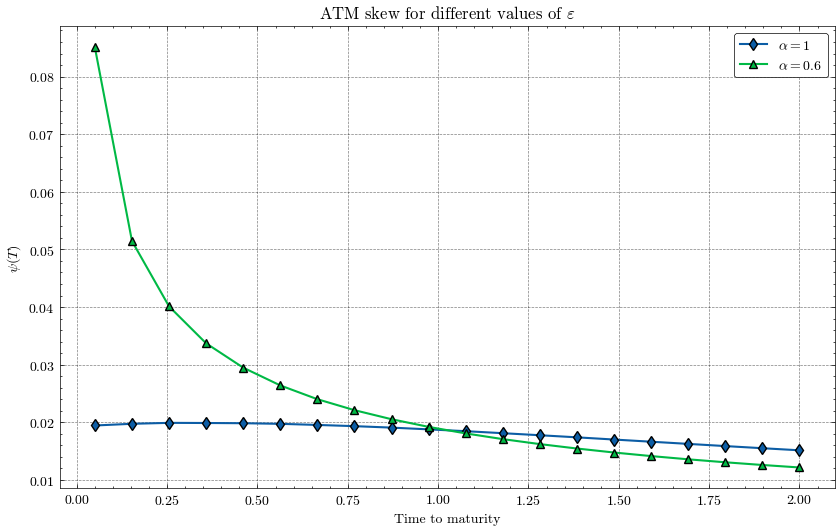

In [665]:
fig = plt.figure(figsize=(10, 6))

plt.plot(
    ttm_grid, atm_skew_heston, lw=1.5, marker="d", ms=6, mec="k", label=r"$\alpha=$1"
)
plt.plot(
    ttm_grid, atm_skew_rough, lw=1.5, marker="^", mec="k", ms=6, label=r"$\alpha=$0.6"
)
legend = plt.legend(loc=0, fancybox=True, edgecolor="k")
legend.get_frame().set_linewidth(0.5)
plt.title(r"ATM skew for different values of $\varepsilon$")
plt.xlabel("Time to maturity")
plt.ylabel(r"$\psi(T)$")
plt.show()

<div class="alert alert-success">We manage to retrieve the atm skew displayed in <a href="https://arxiv.org/pdf/1609.02108.pdf">The characteristic function of rough Heston models</a></div>

In [673]:
rough_model.update(kappa=0, rho=-0.7, theta=0.02, eta=0.3, var=0.02, alpha=0.6, eps=0)

In [674]:
strike_grid = np.linspace(0.8, 1.2, 8)
ttm_grid = np.array([0.02, 0.04, 0.1, 0.25, 0.5, 1])
vol_surface = np.zeros((len(ttm_grid), len(strike_grid)))
errors = np.zeros((len(ttm_grid), len(strike_grid)))

for i, ttm in enumerate(ttm_grid):
    for j, strike in enumerate(strike_grid):
        model_price = rough_put_option(s0, ttm, strike, **rough_model)
        vol_surface[i, j] = implied_vol(s0, ttm, strike, model_price)
        errors[i, j] = np.abs(
            s0 - strike + model_price - bs_price(s0, ttm, strike, vol_surface[i, j])
        )

/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: overflow encountered in square
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in divide
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in square
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: overflow encountered in scalar power
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in scalar power
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in scalar divide
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_4000

In [675]:
mask = np.isnan(vol_surface)
idx = np.where(~mask, np.arange(mask.shape[1]), 0)
np.maximum.accumulate(idx, axis=1, out=idx)
out = vol_surface[np.arange(idx.shape[0])[:, None], idx]

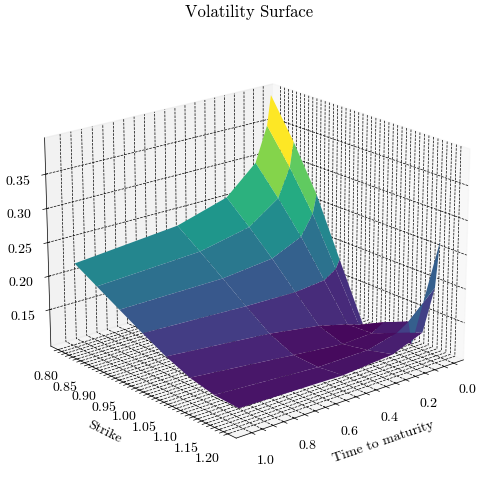

In [676]:
x = np.outer(ttm_grid, np.ones_like(strike_grid))
y = np.outer(strike_grid, np.ones_like(ttm_grid)).T
# generating a figure and a 3D axes
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection="3d")
# plotting the 3D surface plot
ax.plot_surface(x, y, out, cmap="viridis", edgecolor="none")
ax.view_init(20, 50)
plt.xlabel("Time to maturity")
plt.ylabel("Strike")
ax.set_zlabel("Volatility")
plt.title("Volatility Surface")
plt.show()

In [667]:
ttm_grid = np.array([0.02, 0.04, 0.1, 0.25, 0.5, 1])
alpha_list = [0.6, 0.7, 0.8, 0.9, 1]
atm_skew = np.zeros((len(alpha_list), len(ttm_grid)))
dK = 1e-6

for i in tqdm(range(len(alpha_list))):
    rough_model.update(alpha=alpha_list[i])
    for j, ttm in enumerate(ttm_grid):
        price1 = rough_put_option(s0, ttm, s0 * (1 + dK), **rough_model, n=100)
        price2 = rough_put_option(s0, ttm, s0 * (1 - dK), **rough_model, n=100)
        vol1 = implied_vol(s0, ttm, s0 * (1 + dK), price1)
        vol2 = implied_vol(s0, ttm, s0 * (1 - dK), price2)
        atm_skew[i, j] = -s0 * (vol1 - vol2) / (2 * dK)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: overflow encountered in square
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in divide
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in square
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: overflow encountered in scalar power
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in scalar power
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in 

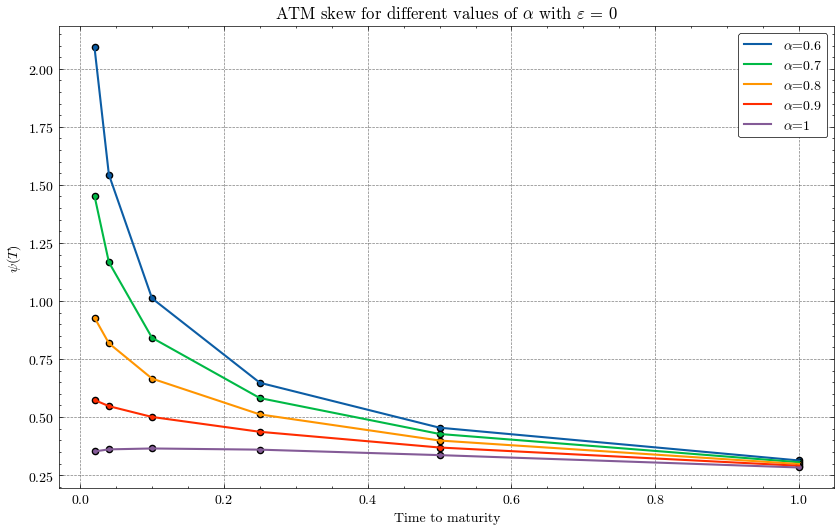

In [668]:
fig = plt.figure(figsize=(10, 6))

for index, alpha in enumerate(alpha_list):
    plt.plot(ttm_grid, atm_skew[index, :], lw=1.5, label=rf"$\alpha$={alpha}")
    plt.scatter(ttm_grid, atm_skew[index, :], marker="o", edgecolors="k", s=20)
legend = plt.legend(
    fancybox=True,
    edgecolor="black",
)
legend.get_frame().set_linewidth(0.5)
plt.title(rf"ATM skew for different values of $\alpha$ with $\varepsilon$ = {0}")
plt.xlabel("Time to maturity")
plt.ylabel(r"$\psi(T)$")
plt.show()

<div class="alert alert-success">We notrice that for very rough processes, ATM skew is higher. This is even more pronounced for short maturities, however, as maturity increases, the skews converge. This seems logical because when processes are very smooth, their prices hardly vary for small maturities, and thus their skews are close to zero. However, when the process is rougher, the price, even if the maturity is short, is likely to vary greatly, hence the high skew. Finally, when maturities are very high, volatility becomes less important compared to drift, and therefore the skew discrepancies following alpha decrease. </div>

In [671]:
rough_model.update(alpha=0.6)
ttm_grid = np.array([0.02, 0.04, 0.1, 0.25, 0.5, 1])
eps_list = [0.002, 0.003, 0.005, 0.01]
atm_skew = np.zeros((len(eps_list), len(ttm_grid)))
dK = 1e-7

for i in tqdm(range(len(eps_list))):
    rough_model.update(eps=eps_list[i])
    for j, ttm in enumerate(ttm_grid):
        price1 = rough_put_option(s0, ttm, s0 * (1 + dK), **rough_model)
        price2 = rough_put_option(s0, ttm, s0 * (1 - dK), **rough_model)
        vol1 = implied_vol(s0, ttm, s0 * (1 + dK), price1)
        vol2 = implied_vol(s0, ttm, s0 * (1 - dK), price2)
        atm_skew[i, j] = -s0 * (vol1 - vol2) / (2 * dK)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: overflow encountered in scalar power
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in scalar power
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in scalar divide
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: overflow encountered in square
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encountered in divide
  + (eta * x) ** 2 / 2
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3644432153.py:35: RuntimeWarning: invalid value encounte

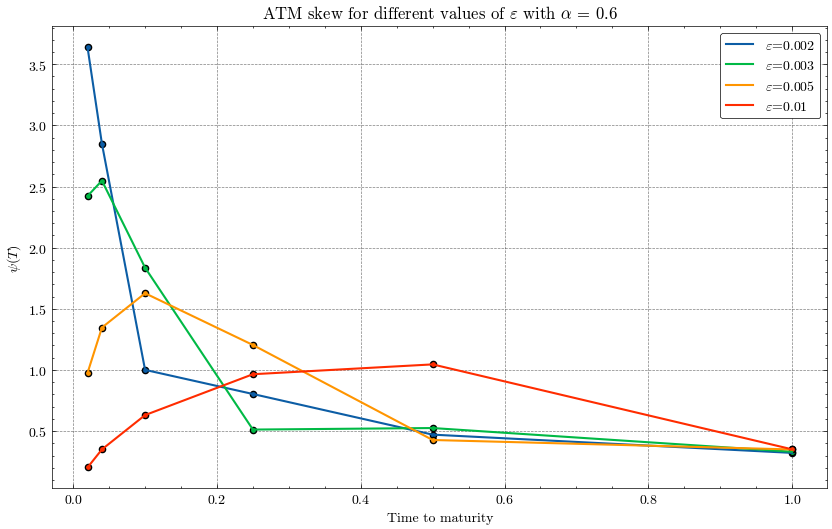

In [672]:
fig = plt.figure(figsize=(10, 6))

for index, eps in enumerate(eps_list):
    plt.plot(ttm_grid, atm_skew[index, :], lw=1.5, label=rf"$\varepsilon$={eps}")
    plt.scatter(ttm_grid, atm_skew[index, :], marker="o", edgecolors="k", s=20)
legend = plt.legend(
    fancybox=True,
    edgecolor="black",
)
legend.get_frame().set_linewidth(0.5)
plt.title(rf"ATM skew for different values of $\varepsilon$ with $\alpha$ = {0.6}")
plt.xlabel("Time to maturity")
plt.ylabel(r"$\psi(T)$")
plt.show()

<div class="alert alert-success"> Adding a drift $\varepsilon >0$ adds regularity to the model since otherwise the kernel explodes in $0$. Modulo some overflow errors, We observe that the model is more coherent with market observations for low values of $\varepsilon$ in term of ATM skew for short maturities as the power law effect is more visible as $\varepsilon \to 0$. Perhaps analysing the ATM skew fit to the market over a large number of assets can reveal the optimal value of $\varepsilon$.</div>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">3. Calibration</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<div class="alert alert-success"> We will attempt to calibrate our models to spx market data. </div>

In [130]:
# Loading data
import pandas as pd

strikes = np.arange(0.5, 1.6, step=0.1)
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])
data = pd.read_csv("spx_surface.csv")
spx_surface = np.concatenate(
    (np.array(data.columns, dtype=float).reshape(1, -1), data.values), axis=0
)

In [134]:
from scipy.optimize import minimize


def loss_function(params):  # params are unpacked as V0, kappa, rho, eta, theta
    model_surface = np.zeros((len(maturities), len(strikes)))
    for i, ttm in enumerate(maturities):
        for j, strike in enumerate(strikes):
            model_price = put_option(s0, ttm, strike, *params)
            model_surface[i, j] = implied_vol(s0, ttm, strike, model_price)
    return np.mean((model_surface - spx_surface) ** 2)

In [193]:
calibration_result = minimize(
    loss_function,
    [V0, kappa, rho, eta, theta],
    method="SLSQP",
    bounds=[(0, None), (0, None), (-1, 1), (0, None), (0, None)],
)
calibration_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0004135176672288891
       x: [ 4.717e-02  1.578e+00 -7.507e-01  6.377e-01  7.240e-02]
     nit: 11
     jac: [ 9.619e-04 -1.694e-04  1.421e-06  2.744e-05  5.918e-04]
    nfev: 67
    njev: 11

In [158]:
calibrated_params = calibration_result.x

In [168]:
from IPython.display import display, Math

display(
    Math(
        rf"\text{{Calibrated parameters}} : V0 = {calibrated_params[0]:.5f}, \kappa = {calibrated_params[1]:.5f}, \rho = {calibrated_params[2]:.5f}, \eta = {calibrated_params[3]:.5f}, \theta = {calibrated_params[4]:.5f}"
    )
)

<IPython.core.display.Math object>

In [194]:
vol_surface = np.zeros((len(maturities), len(strikes)))
for i, ttm in enumerate(maturities):
    for j, strike in enumerate(strikes):
        model_price = put_option(s0, ttm, strike, *calibrated_params)
        vol_surface[i, j] = implied_vol(s0, ttm, strike, model_price)

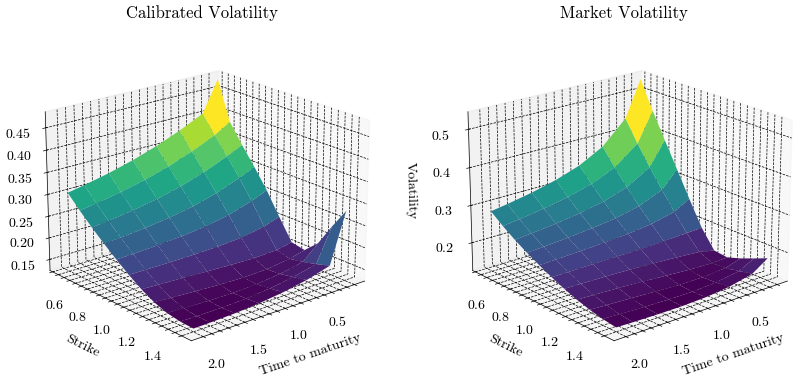

In [195]:
x = np.outer(maturities, np.ones_like(strikes))
y = np.outer(strikes, np.ones_like(maturities)).T
# generating a figure and a 3D axes
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), subplot_kw=dict(projection="3d")
)
# plotting the 3D surface plot
ax1.plot_surface(x, y, vol_surface, cmap="viridis", edgecolor="none")
ax1.view_init(20, 50)
ax1.set_xlabel("Time to maturity")
ax1.set_ylabel("Strike")
ax1.set_zlabel("Volatility")
ax1.set_title("Calibrated Volatility")

ax2.plot_surface(x, y, spx_surface, cmap="viridis", edgecolor="none")
ax2.view_init(20, 50)
ax2.set_xlabel("Time to maturity")
ax2.set_ylabel("Strike")
ax2.set_zlabel("Volatility")
ax2.set_title("Market Volatility")
plt.show()

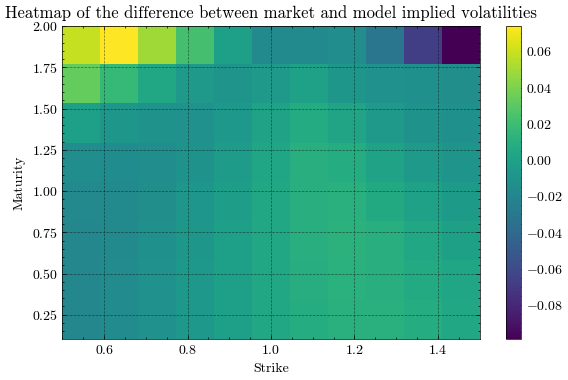

In [207]:
fig = plt.figure(figsize=(6, 4))
plt.imshow(
    spx_surface - vol_surface,
    cmap="viridis",
    extent=[strikes[0], strikes[-1], maturities[-1], maturities[0]],
    aspect="auto",
)
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.colorbar()
plt.title("Heatmap of the difference between market and model implied volatilities")
fig.tight_layout()
plt.show()
plt.close()

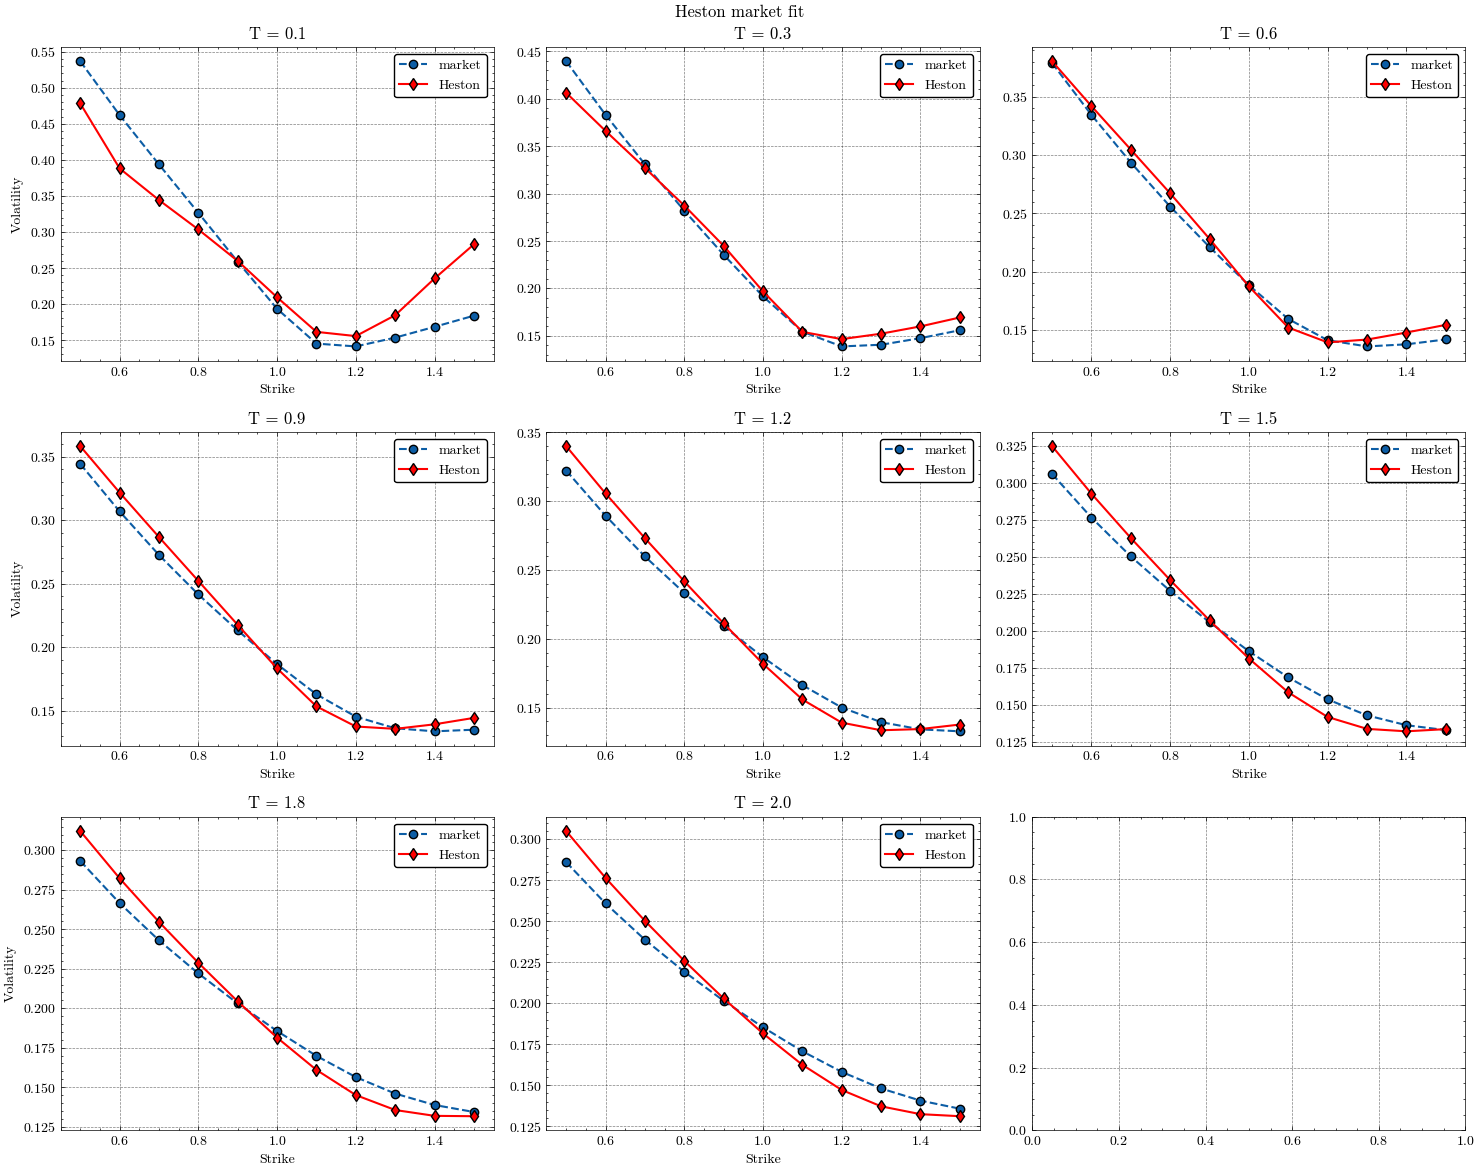

In [253]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, ttm in enumerate(maturities):
    axs[i // 3][i % 3].plot(
        strikes,
        spx_surface[i, :],
        linestyle="--",
        lw=1.5,
        marker="o",
        mec="k",
        ms=6,
        label="market",
    )
    axs[i // 3][i % 3].plot(
        strikes,
        vol_surface[i, :],
        lw=1.5,
        marker="d",
        mec="k",
        ms=6,
        color="red",
        label="Heston",
    )
    axs[i // 3][i % 3].legend(fancybox=True, edgecolor="black", loc=0)
    axs[i // 3][i % 3].set_xlabel("Strike")
    if i % 3 == 0:
        axs[i // 3][i % 3].set_ylabel("Volatility")
    axs[i // 3][i % 3].set_title(f"T = {ttm}")

fig.suptitle("Heston market fit")
fig.tight_layout()
plt.show()
plt.close()

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">4. Learning to Imply volatility</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<div class="alert alert-warning">We notice that the Newton method for computing implied volatility is not very robust as it is very sensitive to the starting value, and the values of Vega. Indeed as we can see below, vega can take very small values which makes the algorithm very unstable.</div>

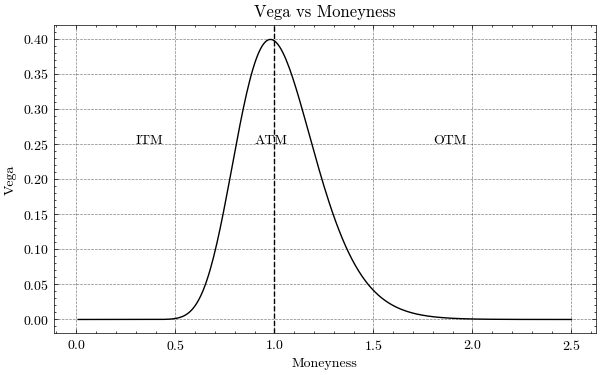

In [27]:
def vega(spot, moneyness, ttm, vol):
    d = np.log(moneyness) / (np.sqrt(ttm) * vol) + 0.5 * np.sqrt(ttm) * vol
    return spot * np.sqrt(ttm) * norm.pdf(d)


moneyness = np.linspace(0.01, 2.5, 300)
fig = plt.figure(figsize=(7, 4))
plt.plot(moneyness, vega(1, moneyness, 1, 0.2), lw=1, color="black")
plt.axvline(x=1, linestyle="--", color="black")
plt.text(x=0.9, y=0.25, s="ATM")
plt.text(x=0.3, y=0.25, s="ITM")
plt.text(x=1.8, y=0.25, s="OTM")
plt.ylabel("Vega")
plt.xlabel("Moneyness")
plt.title("Vega vs Moneyness")
plt.show()
plt.close()

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">If we normalize European call option prices by their strikes, we can write :
$$ \frac{C}{K} = \underbrace{\frac{S_0}{K} \mathcal N (d_+) - \mathcal N(d_-)}_{ = f(m, T, \sigma)}$$ 
Where $m = \frac{S_0}{K}$ is the moneyness of the option. We can try to learn the function :
$$ \sigma_{\text{IV}}: (m, T, \hat C /K) \mapsto f(m, T, \cdot)^{-1}\left(\frac{\hat C}{K} + (m-1)^+\right)$$
Where $\hat C$ is the time value of the option defined as : $\hat C = C - (S_0 - K)^+$.</div>

Since $f$ is known, we can directly generate data according to the same grid as in the article [Pricing options and computing implied volatilities using neural networks](https://arxiv.org/pdf/1901.08943.pdf). We will attempt to approximate the implied volatility via tree based methods and a simple feed forward MLP. 

### Generating synthethic data

In [28]:
n_samples = int(2e6)
sampling_space = dict(moneyness=(0.5, 1.5), ttm=(0.2, 10), volatility=(0.1, 1.0))
sampler = sts.qmc.Halton(d=3, scramble=True, seed=42)
sample = sampler.random(n=n_samples)

sample = np.array(
    [
        sampling_space["moneyness"][1] - sampling_space["moneyness"][0],
        sampling_space["ttm"][1] - sampling_space["ttm"][0],
        sampling_space["volatility"][1] - sampling_space["volatility"][0],
    ]
) * sample + np.array(
    [
        sampling_space["moneyness"][0],
        sampling_space["ttm"][0],
        sampling_space["volatility"][0],
    ]
)


def bs_norm(moneyness: float, ttm: float, vol: float) -> float:
    """Black Scholes formula for European Call option price normalized by strike
    Args:
        - moneyness: spot over strike
        - ttm: time to maturity
        - vol: volatility
    Returns:
        - float: price of the Call option"""
    if vol == 0:
        return np.maximum(moneyness - 1, 0)
    d1 = np.log(moneyness) / (np.sqrt(ttm) * vol) + 0.5 * np.sqrt(ttm) * vol
    d2 = d1 - np.sqrt(ttm) * vol

    return moneyness * sts.norm.cdf(d1) - sts.norm.cdf(d2)


normalized_price = np.zeros(n_samples)
for i in tqdm(range(sample.shape[0])):
    normalized_price[i] = bs_norm(*sample[i])

time_value = normalized_price - np.maximum(sample[:, 0] - 1, 0)

100%|██████████████████████████████| 2000000/2000000 [01:52<00:00, 17773.87it/s]


In [29]:
from sklearn.model_selection import train_test_split

indices = (
    time_value > 1e-7
)  # Threshold defined in the article https://arxiv.org/pdf/1901.08943.pdf
X = np.concatenate(
    (
        sample[indices, 0].reshape(-1, 1),
        sample[indices, 1].reshape(-1, 1),
        time_value[indices].reshape(-1, 1),
    ),
    axis=1,
)
Y = sample[indices, 2].reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

In [30]:
# summary statistics utilities
def residuals_diagnostic(
    y_true,
    y_pred,
    resid_density=norm.pdf,
    resid_density_name="Gaussian",
    density_range=None,
):
    residuals = y_true - y_pred
    r2 = r2_score(y_true, y_pred)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    ax1.scatter(y_pred, residuals, s=20, color="white", edgecolors="k")

    ax1.set_title("Residuals vs Fitted values")
    ax1.set_xlabel("fitted values")
    ax1.set_ylabel("residuals")

    ax2.hist(
        residuals,
        bins=100,
        edgecolor="k",
        density=True,
        color="white",
        label="Validation residuals",
    )
    if density_range is None:
        density_range = (-0.010, 0.007)
    mean = residuals.mean()
    std = residuals.std()
    if resid_density == sts.laplace.pdf:
        std = std / np.sqrt(2)
    ax2.plot(
        np.linspace(density_range[0], density_range[1], num=200),
        resid_density(
            np.linspace(density_range[0], density_range[1], num=200),
            loc=mean,
            scale=std,
        ),
        lw=1.5,
        linestyle="--",
        color="black",
        label=f"Fitted {resid_density_name}",
    )
    # ax2.set_xlim(left=-0.0075, right=0.005)
    ax2.set_xlabel("residuals")
    ax2.set_ylabel("density")
    ax2.legend(loc=0)
    ax2.set_title("Residuals distribution")

    ax3.scatter(
        y_true,
        y_pred,
        s=20,
        edgecolor="k",
        color="white",
        label=rf"$R^2$={r2:.5f}",
    )
    ax3.legend(loc=0)
    ax3.set_title("Fitted values vs Target values")
    ax3.set_xlabel("target values")
    ax3.set_ylabel("fitted values")
    fig.tight_layout()
    plt.show()
    plt.close()

### Fitting a gradient boosting model

In [31]:
import pickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


param_grid = {
    "n_estimators": [500, 700, 900, 1000],
    "max_depth": [10, 12, 15],
    "learning_rate": [0.05],
    "n_jobs": [-1],
}

grid_search = GridSearchCV(
    xgb.XGBRegressor(),
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    verbose=2,
)
# grid_search.fit(X_train, Y_train)
# model = grid_search.best_estimator_

# pickle.dump(model, open("iv_xgb_2.pkl", "wb"))

In [32]:
iv_xgb = pickle.load(open("iv_xgb_2.pkl", "rb"))
iv_xgb

/Users/saad/anaconda3/envs/stats/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [02:15:02] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

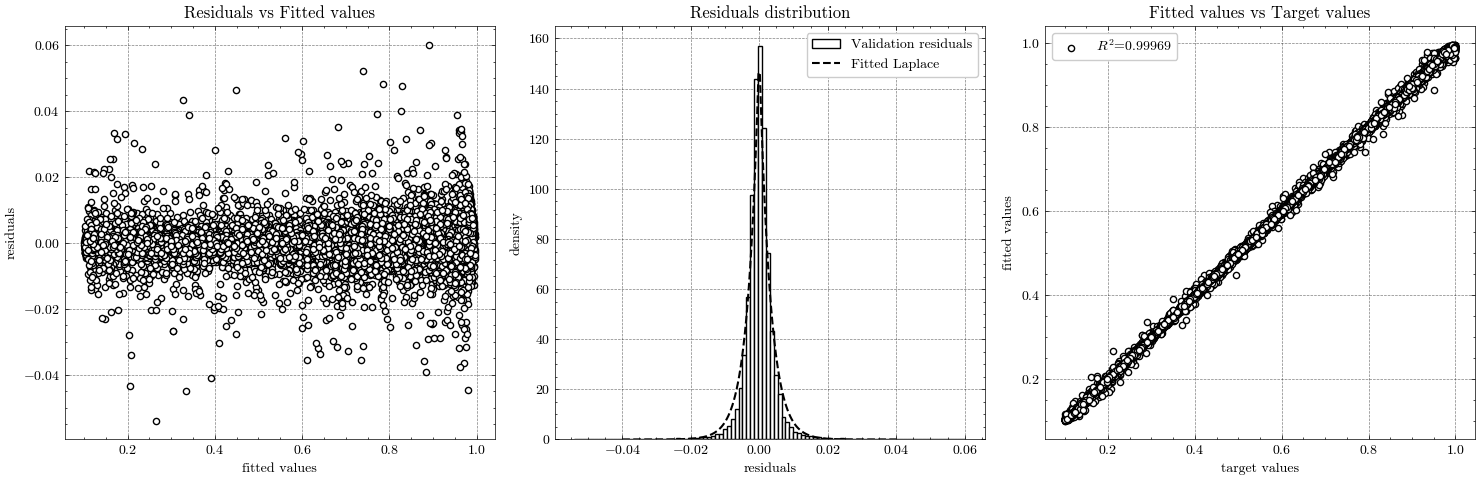

In [33]:
predictions = iv_xgb.predict(X_test[:20000, :])
residuals_diagnostic(
    Y_test[:20000].ravel(),
    predictions,
    resid_density=sts.laplace.pdf,
    resid_density_name="Laplace",
    density_range=(-0.04, 0.04),
)
# Due to computational considerations we are not able to show a fit on the entire test dataset

<div class="alert alert-warning"> The model fits the data reasonably well, the residual distribution is very similar to a Laplace distribution and the residuals vs fitted values do not exhibit any pattern. The issue is that the precision of the model is not very satisfactory, a percentage or two in volatility scale is quite major. </div>

In [209]:
strike_grid = np.linspace(0.8, 1.2, 8)
ttm_grid = np.linspace(0.2, 1, 10)
vol_surface_xgb = np.zeros((len(ttm_grid), len(strike_grid)))
vol_surface_newton = np.zeros((len(ttm_grid), len(strike_grid)))

for i, ttm in enumerate(ttm_grid):
    for j, strike in enumerate(strike_grid):
        model_price = put_option_cos(s0, ttm, strike, **model, N=96)
        time_value = (s0 - strike + model_price - np.maximum(s0 - strike, 0)) / strike
        vol_surface_xgb[i, j] = iv_xgb.predict(
            np.array([s0 / strike, ttm, time_value.item()]).reshape(1, -1)
        )
        vol_surface_newton[i, j] = implied_vol(s0, ttm, strike, model_price)

/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/4163986002.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol_surface_xgb[i, j] = iv_xgb.predict(
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/4163986002.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol_surface_newton[i, j] = implied_vol(s0, ttm, strike, model_price)


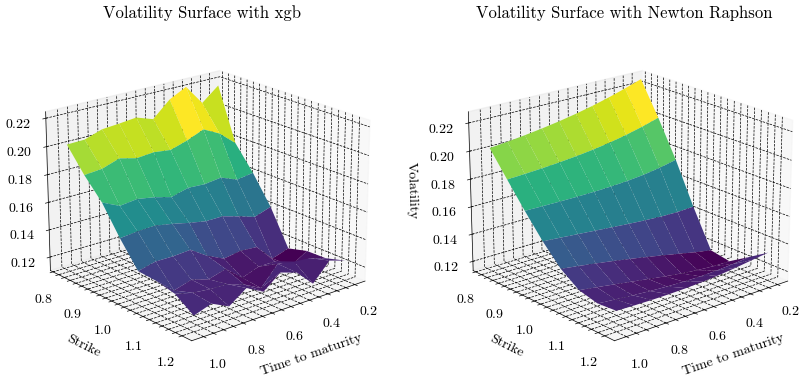

In [210]:
x = np.outer(ttm_grid, np.ones_like(strike_grid))
y = np.outer(strike_grid, np.ones_like(ttm_grid)).T
# generating a figure and a 3D axes
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), subplot_kw=dict(projection="3d")
)
# plotting the 3D surface plot
ax1.plot_surface(x, y, vol_surface_xgb, cmap="viridis", edgecolor="none")
ax1.view_init(20, 50)
ax1.set_xlabel("Time to maturity")
ax1.set_ylabel("Strike")
ax1.set_zlabel("Volatility")
ax1.set_title("Volatility Surface with xgb")

ax2.plot_surface(x, y, vol_surface_newton, cmap="viridis", edgecolor="none")
ax2.view_init(20, 50)
ax2.set_xlabel("Time to maturity")
ax2.set_ylabel("Strike")
ax2.set_zlabel("Volatility")
ax2.set_title("Volatility Surface with Newton Raphson")
plt.show()

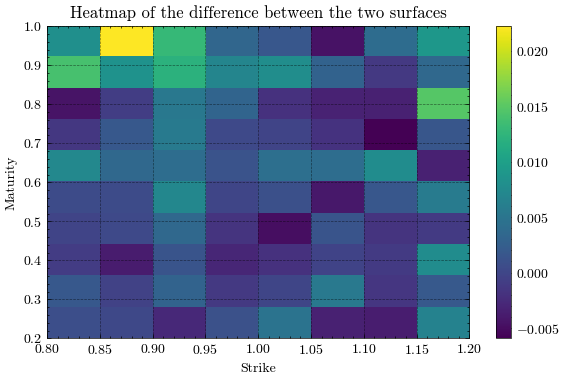

In [214]:
fig = plt.figure(figsize=(6, 4))
plt.imshow(
    vol_surface_newton - vol_surface_xgb,
    cmap="viridis",
    extent=[strike_grid[0], strike_grid[-1], ttm_grid[-1], ttm_grid[0]],
    aspect="auto",
)
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.colorbar()
plt.title("Heatmap of the difference between the two surfaces")
fig.tight_layout()
plt.show()
plt.close()

<div class="alert alert-warning">In the test above, we attempted to recreate a vol surface for prices given by the COS method. We can clearly see that our regression model reproduces the general shape of the volatility surface but is sometimes off by nearly $3\%$ which remains considerable. And above all the volatility surface that the boosting model outputs is not very smooth.</div>

<div class="alert alert-success"> We will now attempt to learn the implied volatility using an MLP. We follow the suggestions of the article <a href="https://arxiv.org/pdf/1901.08943.pdf">Pricing options and computing implied volatilities
using neural networks</a> in term of architecture and log scaling of the time value. We will use an MLP with $5$ hidden layers, $400$ neurons in each layer, and SiLU activations between each layer. Due to the the fact that volatility is between $0$ and $1$, we will run our network output through a sigmoid function.</div>

In [312]:
import torch
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

implied_vol_config = dict(
    input_dim=3,
    output_dim=1,
    nb_neurons=400,
    depth=4,
    activation=nn.SiLU(),
    lr=0.005,
    batch_size=1024,
    epochs=5000,
)


class MLP(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        nb_neurons,
        depth,
        activation=nn.SiLU(),
    ):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, nb_neurons)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(nb_neurons, nb_neurons) for _ in range(depth - 1)]
        )
        self.output_layer = nn.Linear(nb_neurons, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        return self.output_layer(x)

In [313]:
iv_nn = MLP(
    implied_vol_config["input_dim"],
    implied_vol_config["output_dim"],
    implied_vol_config["nb_neurons"],
    implied_vol_config["depth"],
    activation=implied_vol_config["activation"],
).to(device)
optimizer = optim.SGD(iv_nn.parameters(), lr=implied_vol_config["lr"], momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10, step_size_down=10
)
iv_nn

MLP(
  (input_layer): Linear(in_features=3, out_features=400, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=400, out_features=400, bias=True)
  )
  (output_layer): Linear(in_features=400, out_features=1, bias=True)
  (activation): SiLU()
)

In [314]:
learning_rate = []
for i in range(80):
    learning_rate.append(scheduler.get_last_lr())
    scheduler.step()

/Users/saad/anaconda3/envs/stats/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


<div class="alert alert-success"> In our training we used a Cyclir learning rate scheduler. </div>

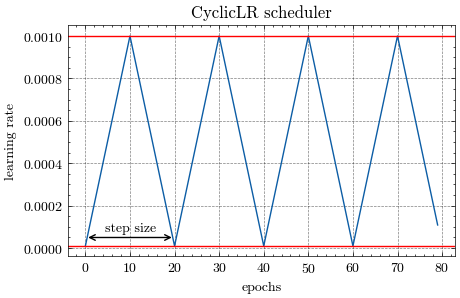

In [315]:
fig = plt.figure(figsize=(5, 3))

plt.plot(
    np.arange(80),
    learning_rate,
)
plt.axhline(y=0.001, color="red")
plt.axhline(y=0.00001, color="red")
plt.annotate(
    text="", xy=(20, 0.00005), xytext=(0, 0.00005), arrowprops=dict(arrowstyle="<->")
)
plt.text(x=4.5, y=0.00008, s="step size")
plt.xlabel("epochs")
plt.ylabel("learning rate")
plt.title("CyclicLR scheduler")
plt.show()
plt.close()

In [316]:
# Log scaling the time value
X_train_mlp = np.copy(X_train)
X_train_mlp[:, 2] = np.log(X_train[:, 2])
X_test_mlp = np.copy(X_test)
X_test_mlp[:, 2] = np.log(X_test[:, 2])

In [317]:
# Creating DataLoaders
dtype = torch.float
dataset_train = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train_mlp).type(dtype), torch.from_numpy(Y_train).type(dtype)
)
dataset_test = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test_mlp).type(dtype), torch.from_numpy(Y_test).type(dtype)
)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1024, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1024, shuffle=False)

In [318]:
from collections import deque


def train(model, optimizer, epochs, desc):
    training_loss = deque()
    validation_loss = deque()
    with tqdm.tqdm(total=epochs, desc=desc, position=0, leave=True) as progress_bar:
        best_validation_loss = float("inf")
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for inputs, targets in loader_train:
                inputs = inputs.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
            train_loss = train_loss / len(loader_train)
            training_loss.append(train_loss)
            if epoch % 5 == 0:
                model.eval()
                valid_loss = 0
                with torch.no_grad():
                    for inputs, targets in loader_test:
                        inputs = inputs.to(device)
                        targets = targets.to(device)
                        outputs = model(inputs)
                        loss = loss_fn(outputs, targets)
                        valid_loss += loss.item()
                valid_loss = valid_loss / len(loader_test)
                validation_loss.append(valid_loss)
                if valid_loss < best_validation_loss:
                    print("Checkpoint")
                    torch.save(model.state_dict(), "checkpoint.pth")
                    best_validation_loss = valid_loss

                logs = f"Epoch: {epoch}, lr = {scheduler.get_last_lr()}, training_loss = {train_loss}, validation_loss = {valid_loss}"
            else:
                logs = f"Epoch: {epoch}, lr = {scheduler.get_last_lr()}, training_loss = {train_loss}"
            scheduler.step()
            print(logs)
            # progress_bar.update()
            # progress_bar.set_description(desc=logs)

    return training_loss, validation_loss


# iv_nn.load_state_dict(torch.load("checkpoint.pth"))
# training_loss, validation_loss = train(
#     iv_nn, optimizer, implied_vol_config["epochs"], "Training Implied Vol"
# )
# np.save("training_loss_iv", training_loss)
# np.save("validation_loss_iv", validation_loss)
# torch.save(model.state_dict(), "checkpoint2.pth")

<div class="alert alert-success">We ran the training loop in a remote cluster to leverage GPU access instead of running it locally on this notebook. But we test the model on cpu in what follows.</div>

In [677]:
iv_nn.load_state_dict(torch.load("checkpoint.pth", map_location=device))
iv_nn.eval()
training_loss_iv = np.load("training_loss_iv.npy")
validation_loss_iv = np.load("validation_loss_iv.npy")

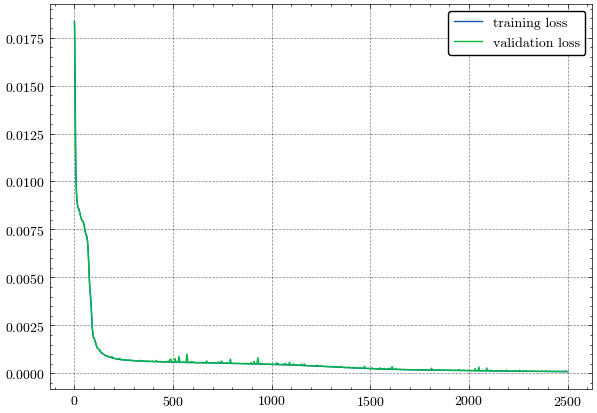

In [678]:
fig = plt.figure(figsize=(7, 5))
epochs = np.arange(len(training_loss_iv))
plt.plot(epochs, training_loss_iv[epochs], label="training loss")
plt.plot(epochs[epochs % 5 == 0], validation_loss_iv, label="validation loss")
plt.legend(fancybox=True, edgecolor="black", loc=0)
plt.show()
plt.close()

In [679]:
%%timeit
predictions = []
for inputs, targets in loader_test:
    inputs = inputs.to(device)
    with torch.no_grad():
        predictions.append(iv_nn(inputs))
predictions = np.concatenate(predictions, axis=0)

1.6 s ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div class="alert alert-success">One of the major advantages of this approache is that we can easily compute implied volatilities in batches and as we can see here it only took around $1.6$ seconds to infer almost $400000$ implied volatilitie on cpu.</div>

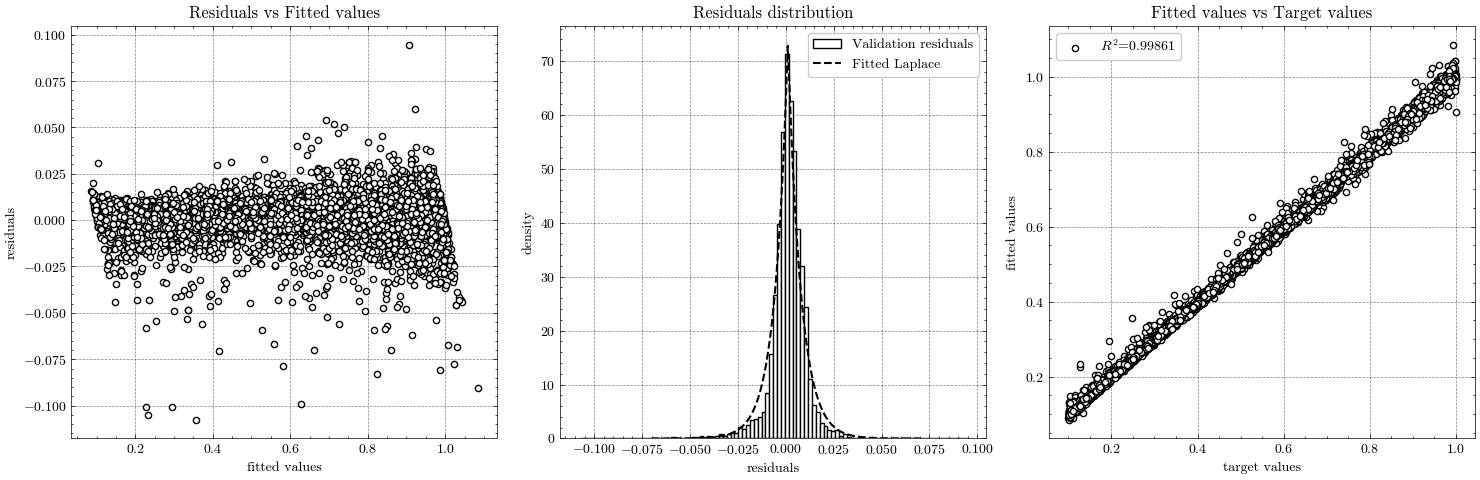

In [684]:
indices = rng.choice(len(Y_test), size=10000)
residuals_diagnostic(
    Y_test.ravel()[indices],
    predictions.ravel()[indices],
    resid_density=sts.laplace.pdf,
    resid_density_name="Laplace",
    density_range=(-0.07, 0.07),
)

In [681]:
strike_grid = np.linspace(0.8, 1.2, 8)
ttm_grid = np.linspace(0.2, 1, 10)
vol_surface_nn = np.zeros((len(ttm_grid), len(strike_grid)))
vol_surface_newton = np.zeros((len(ttm_grid), len(strike_grid)))

for i, ttm in enumerate(ttm_grid):
    for j, strike in enumerate(strike_grid):
        model_price = put_option_cos(s0, ttm, strike, **model, N=96)
        time_value = (s0 - strike + model_price - np.maximum(s0 - strike, 0)) / strike
        vol_surface_nn[i, j] = iv_nn(
            torch.tensor([s0 / strike, ttm, np.log(time_value)], dtype=torch.float).to(
                device
            )
        )
        vol_surface_newton[i, j] = implied_vol(s0, ttm, strike, model_price)

/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3828019059.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  torch.tensor([s0 / strike, ttm, np.log(time_value)], dtype=torch.float).to(
/var/folders/ql/fnw2mjwn4bddvlr9hcy8lx_40000gn/T/ipykernel_54120/3828019059.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol_surface_newton[i, j] = implied_vol(s0, ttm, strike, model_price)


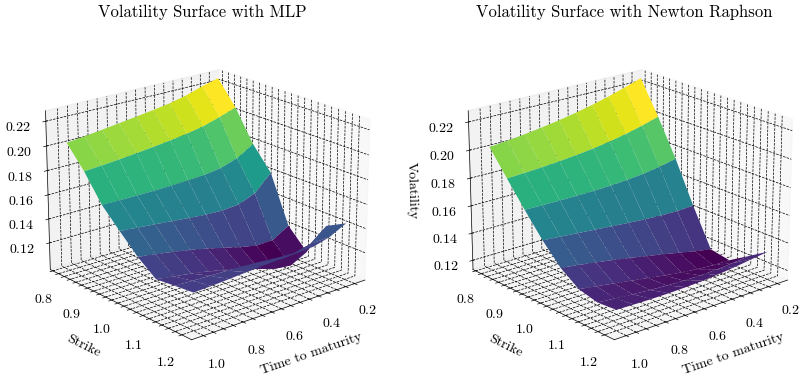

In [682]:
x = np.outer(ttm_grid, np.ones_like(strike_grid))
y = np.outer(strike_grid, np.ones_like(ttm_grid)).T
# generating a figure and a 3D axes
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), subplot_kw=dict(projection="3d")
)
# plotting the 3D surface plot
ax1.plot_surface(x, y, vol_surface_nn, cmap="viridis", edgecolor="none")
ax1.view_init(20, 50)
ax1.set_xlabel("Time to maturity")
ax1.set_ylabel("Strike")
ax1.set_zlabel("Volatility")
ax1.set_title("Volatility Surface with MLP")

ax2.plot_surface(x, y, vol_surface_newton, cmap="viridis", edgecolor="none")
ax2.view_init(20, 50)
ax2.set_xlabel("Time to maturity")
ax2.set_ylabel("Strike")
ax2.set_zlabel("Volatility")
ax2.set_title("Volatility Surface with Newton Raphson")
plt.show()

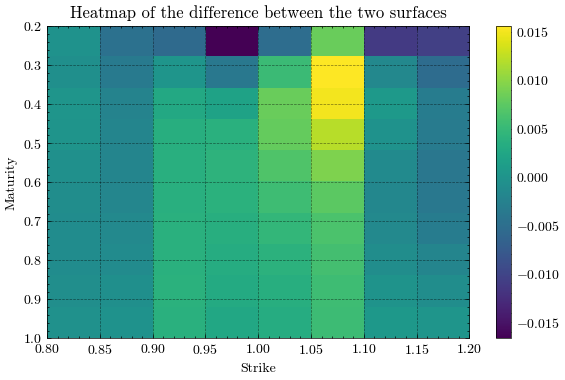

In [683]:
fig = plt.figure(figsize=(6, 4))
plt.imshow(
    vol_surface_newton - vol_surface_nn,
    cmap="viridis",
    extent=[strike_grid[0], strike_grid[-1], ttm_grid[-1], ttm_grid[0]],
    aspect="auto",
)
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.colorbar()
plt.title("Heatmap of the difference between the two surfaces")
fig.tight_layout()
plt.show()
plt.close()

<div class="alert alert-warning">We ran our training loop for $5000$ epochs, we do not know why the model struggles to learn implied volatility for moneyness values around 1. But we notice that the volatility surface it produces is much smoother than what we get via boosting. The training and validation losses of the network keep decreasing although slowly, so we expect the performance to increase with the number of epochs. We could also choose a larger mlp since we aim to overfit overfit our data.</div>